In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy as sp
import os
import sys
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import empty, arange, average, minimum, maximum
from numpy.random import RandomState
from sklearn.neural_network import MLPClassifier
import sklearn.preprocessing
from tensorflow.python.keras.backend_config import epsilon
from tensorflow.python.ops import math_ops
import scipy.stats

from access_data import read_gaussian_data, read_bliss_data

2021-07-15 12:53:43.916227: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Path to the extracted data from Zenodo
DATA_PATH = "../galactics_attack_data/"

In [3]:
training_data = read_bliss_data(DATA_PATH, "data_device_a_attack_1_2")

# 1) Attack Using "Perfect Side-Channel" Data

This section checks that the prefect data without a side-channel is correct.

In [4]:
# trunkcate to first half
for col in ['yu', 'Kx', 'z']:
    training_data[col] = training_data.apply(lambda row: row[col][:512], axis=1)

# filter b to relevant bit
training_data['b'] = training_data.apply(lambda row: 1 - (row['b'] % 2), axis=1)

#filter z to aquire a
training_data['a'] = training_data.apply(lambda row: np.sign(row['z']), axis=1)
training_data['a'] = training_data.apply(lambda row: np.where(row['a'] == -1, 1, 0), axis=1)

# Transpose C_matrix
training_data['C_matrix'] = training_data.apply(lambda row: row['C_matrix'].T, axis=1)
    
# compute corresponding trace index (discarding failed attempts)
training_data['trace_idx'] = np.cumsum(training_data['num_attempts']) - 1

For each row in the table, we have that $$z = (-1)^a(Kx + y_\text{u}) + (-1)^b \langle s, c \rangle.$$ 

In [5]:
# Check if the data is correct
for _, row in training_data.iterrows():
    assert (row['s1c'] + (-1)**row['a']*(row['Kx'] + row['yu']) == row['z1']).all()

If $y_\text{u} = 0$, we have $$z = (-1)^aKx + (-1)^b \langle s, c \rangle.$$
How to compute s?

From above equation, we got

$$ \sum s_ic_i = \left(c_1,\dots,c_n\right) \left(\begin{array}{c}s_1 \\ \vdots \\ s_n\end{array}\right) = \frac{z - (-1)^aKx}{(-1)^b} $$

Repeating this process many times, we obtain many equations of this kind. Arranging them in a equation system we obtain:

$$
\left(
\begin{array}{ccc}
c_{1,1} & \dots  & c_{1,n} \\
        & \ddots &         \\
c_{n,1} &        & c_{n,n} 
\end{array}
\right)
\left(
\begin{array}{c}
s_1 \\ \vdots \\ s_n
\end{array}
\right)
=
\left(
\begin{array}{c}
\frac{z_1 - (-1)^{a_1}Kx_1}{(-1)^{b_1}} \\
\vdots \\
\frac{z_n - (-1)^{a_n}Kx_n}{(-1)^{b_n}} \\
\end{array}
\right)
$$

### Compute $\langle s, c \rangle$

We're using the fact that $\langle s, c \rangle = sC$ and check that  $$ \sum s_ic_i = \left(c_1,\dots,c_n\right) \left(\begin{array}{c}s_1 \\ \vdots \\ s_n\end{array}\right) = \frac{z - (-1)^aKx}{(-1)^b} $$

In [6]:
def compute_s1c(row):
    return (-1)**row['b'] * (row['s1'] @ row['C_matrix'])

training_data['s1c_verify'] = training_data.apply(compute_s1c, axis=1)

# Check if the calculated sc is the same as the actual sc
for _, row in training_data.iterrows():
    assert (row['s1c'] == row['s1c_verify']).all()

## Build a system of linear equations

We compute s from the equation system mentioned above:

$$
\left(
\begin{array}{ccc}
c_{1,1} & \dots  & c_{1,n} \\
        & \ddots &         \\
c_{n,1} &        & c_{n,n} 
\end{array}
\right)
\left(
\begin{array}{c}
s_1 \\ \vdots \\ s_n
\end{array}
\right)
=
\left(
\begin{array}{c}
\frac{z_1 - (-1)^{a_1}Kx_1}{(-1)^{b_1}} \\
\vdots \\
\frac{z_n - (-1)^{a_n}Kx_n}{(-1)^{b_n}} \\
\end{array}
\right)
$$

In [7]:
LHS = []
RHS = []

done = False

# iterate over traces
for j, row in training_data.iterrows():
    if done:
        break
    
    # iterate over elements of the vectors
    for i, yui in enumerate(row['yu']):
        if yui == 0:  # we have a side-channel for this
            C = row['C_matrix']  # C is a function of the challenge c, not only public but also attacker-chosen
            z = row['z1'][i]  # public as part of the signature
            Kx = row['Kx'][i]  # side-channel on Kx
            a = row['a'][i]  # side-channel on the cflip of z
            b = row['b']  # side-channel on b using cflip
            
            rhs = (z - ((-1)**a*Kx))/((-1)**b)
            lhs = C[:, i] 
            RHS.append(rhs)
            LHS.append(lhs)
            
            if len(LHS) == 512:
                print(f'Used {j+1} rows of data (=signatures)')
                done = True
                break

assert len(RHS) >= 512, 'Not enough data'
                
LHS, RHS = np.array(LHS), np.array(RHS)
LHS = LHS[:512]
RHS = RHS[:512]
assert np.linalg.matrix_rank(LHS) == 512, f'Rank should 512 but was {np.linalg.matrix_rank(LHS)}'
our_s = np.round(np.linalg.solve(LHS, RHS), 8)
real_s = training_data.iloc[0]['s1']

Used 246 rows of data (=signatures)


In [8]:
# Check that the result is correct
(our_s == real_s).all()

True

# 2) Attack Using Side-Channel Data

## 2.1) Profiling Phase 

Loading training data

In [9]:
# This path has to be the path to the traced data after preprocessing
training_data_path = DATA_PATH + "data_device_a_attack_1_2/"

In [10]:
# Loding the data
training_kx_data = pd.read_pickle(training_data_path + 'Kx_const_cw_data.pickle')
training_yu_data = pd.read_pickle(training_data_path + 'yu_cw_data.pickle')
training_z_cflip_data = pd.read_pickle(training_data_path + 'z_cflip_cw_data.pickle')
training_sc_cflip_data = pd.read_pickle(training_data_path + 'sc_cflip_cw_data.pickle')

In [11]:
training_kx_data.reset_index(inplace=True)
training_yu_data.reset_index(inplace=True)
training_z_cflip_data.reset_index(inplace=True)
training_sc_cflip_data.reset_index(inplace=True)

## $Kx$ Side-Channel Training

Each trace consists of 1924 samples. Only the samples [1890, 1920] are of interest for the side-channel leakage.

In [12]:
training_kx_data['trace'] = training_kx_data.apply(lambda row: row['trace'][1890:1920], axis=1)

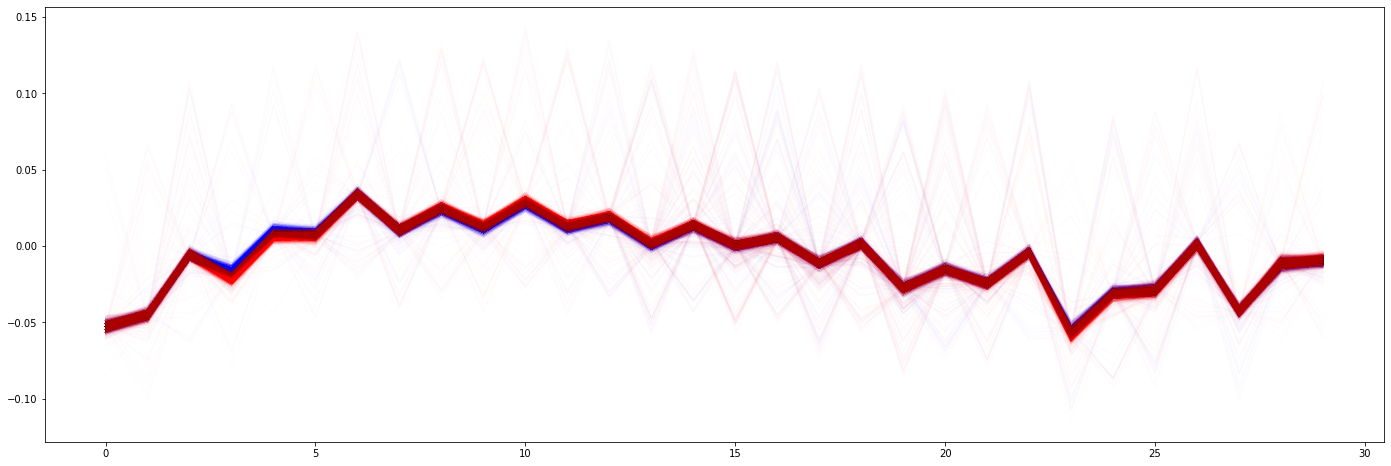

In [13]:
plt.figure(figsize=(24, 8))

for cf, zgdata in training_kx_data.groupby(['Kx']): 
    for idx, row in zgdata[:1000].iterrows():   
        plt.plot(row['trace'], alpha=.01, color=('red' if cf else 'blue'))

In [14]:
def series_to_numpy(s):
    assert len(s), 's must contain at least one row'
    l1, l2, t = len(s), len(next(iter(s))), next(iter(s)).dtype
    res = np.empty(shape=(l1, l2))
    for idx, row in enumerate(s):
        res[idx] = row
    return res

In [15]:
training_kx_data['status'] = 'train'
X_kx_train = series_to_numpy(training_kx_data[training_kx_data['status'] == 'train']['trace'])
Y_kx_train = training_kx_data[training_kx_data['status'] == 'train']['Kx'].to_numpy()
X_kx_train = sklearn.preprocessing.StandardScaler().fit_transform(X_kx_train)

Train $K_x$ classifier

In [16]:
kx_clf = MLPClassifier(
    random_state=42,
    solver='adam', 
    learning_rate='adaptive',
    max_iter=50,
    hidden_layer_sizes=[20],
    batch_size=500,
    early_stopping=True,
    n_iter_no_change=100,
    verbose=True,
    activation='tanh',
)
kx_clf.fit(X_kx_train , Y_kx_train)

Iteration 1, loss = 0.50255045
Validation score: 0.951555
Iteration 2, loss = 0.16662457
Validation score: 0.960363
Iteration 3, loss = 0.13279151
Validation score: 0.963618
Iteration 4, loss = 0.11164186
Validation score: 0.968137
Iteration 5, loss = 0.09702233
Validation score: 0.972580
Iteration 6, loss = 0.08751620
Validation score: 0.974839
Iteration 7, loss = 0.08096958
Validation score: 0.976486
Iteration 8, loss = 0.07597435
Validation score: 0.977597
Iteration 9, loss = 0.07264815
Validation score: 0.977903
Iteration 10, loss = 0.07039890
Validation score: 0.978133
Iteration 11, loss = 0.06875577
Validation score: 0.978669
Iteration 12, loss = 0.06748406
Validation score: 0.978937
Iteration 13, loss = 0.06656542
Validation score: 0.978899
Iteration 14, loss = 0.06559466
Validation score: 0.979167
Iteration 15, loss = 0.06489399
Validation score: 0.979243
Iteration 16, loss = 0.06419250
Validation score: 0.979282
Iteration 17, loss = 0.06359415
Validation score: 0.979396
Iterat

/home/patrick/GALACTICS-Side-Channel-Attacks/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', batch_size=500, early_stopping=True,
              hidden_layer_sizes=[20], learning_rate='adaptive', max_iter=50,
              n_iter_no_change=100, random_state=42, verbose=True)

Text(0.5, 0, 'Normalized Voltage')

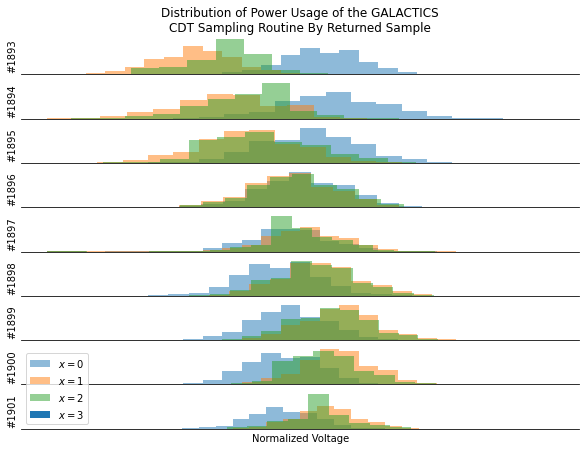

In [17]:
HISTPLOT = list(range(3,12))
f, axes = plt.subplots(nrows=len(HISTPLOT), ncols=1, figsize=(10, .8*len(HISTPLOT)))

LABELS = {'$x=0$': 0, '$x=1$': 256, '$x=2$': 512, '$x=3$': 786, '$x=4$': 1024}

for i, ax in zip(HISTPLOT, axes):
    for j, (l, lval) in enumerate(LABELS.items()):
        v = X_kx_train[Y_kx_train==lval][:, i]
        if len(v) == 0: continue
        v = v[np.abs(v) < 2]
        ax.hist(v, density=True, bins=np.linspace(np.min(v), np.max(v), len(np.unique(v))-1), alpha=.5)
    ax.set_ylabel(f'#{1890+i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

axes[0].set_title('Distribution of Power Usage of the GALACTICS\nCDT Sampling Routine By Returned Sample')
axes[-1].legend(LABELS.keys())
axes[-1].set_xlabel('Normalized Voltage')

## $y_u$ Side-Channel Training

Each trace consists of 268 samples. Only the samples [85, 110] are of interest for the side-channel leakage.

In [18]:
training_yu_data['yu=0'] = training_yu_data['yu'] == 0
training_yu_data['trace'] = training_yu_data.apply(lambda row: row['trace'][85:110], axis=1)

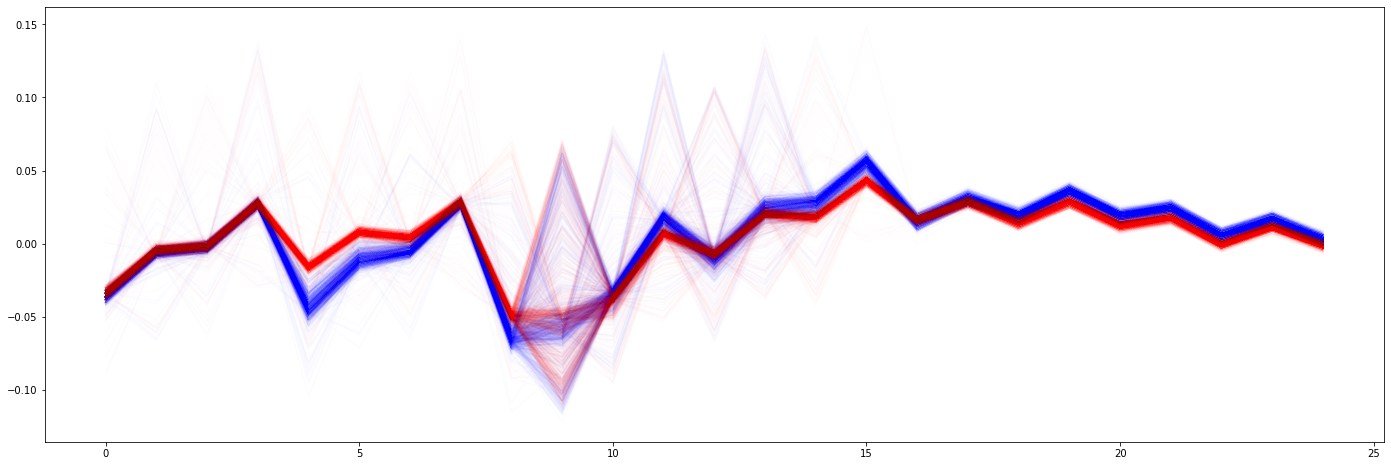

In [19]:
plt.figure(figsize=(24, 8))

for cf, zgdata in training_yu_data.groupby(['yu=0']): 
    for idx, row in zgdata[:1000].iterrows():   
        plt.plot(row['trace'], alpha=.01, color=('red' if cf else 'blue'))

In [20]:
trace_shape = next(iter(training_yu_data['trace'])).shape

In [21]:
training_yu_data['status'] = 'train'
X_yu_train = series_to_numpy(training_yu_data[training_yu_data['status'] == 'train']['trace'])
Y_yu_train = training_yu_data[training_yu_data['status'] == 'train']['yu=0'].to_numpy()
X_yu_train = sklearn.preprocessing.StandardScaler().fit_transform(X_yu_train)

Train $y_u$ classifier

In [22]:
pos = sum(Y_yu_train)
neg = sum(~Y_yu_train)
total = len(Y_yu_train)

class_weight = {
    0: (1 / neg)*(total)/2, 
    1: (1 / pos)*(total)/2,
}

init_bias = np.log(pos/neg)

import models
yu_clf = models.get_yu_model(trace_shape, init_bias)

# fit
history = yu_clf.fit(
    X_yu_train, Y_yu_train.astype(np.float32),
    epochs=80,
    batch_size=len(X_yu_train)//5,
    callbacks=[],
    shuffle=True,
    validation_split=0.2,
    class_weight=class_weight,
).history

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-07-15 12:56:03.671281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 12:56:03.700080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-07-15 12:56:03.700592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-07-15 12:56:03.700631: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 12:56:03.703189: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

Epoch 1/80
4/4 [==============================] - 5s 929ms/step - loss: 8.2400 - fp: 0.0000e+00 - accuracy: 0.9960 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0040 - tn_loss: 0.0654 - fp_loss: 0.2690 - fn_loss: 0.0642 - tp_loss: 2.7525e-04 - val_loss: 0.3797 - val_fp: 0.0000e+00 - val_accuracy: 0.9961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0039 - val_tn_loss: 0.0635 - val_fp_loss: 0.2536 - val_fn_loss: 0.0623 - val_tp_loss: 2.6517e-04
Epoch 2/80
4/4 [==============================] - 2s 454ms/step - loss: 8.2288 - fp: 0.0000e+00 - accuracy: 0.9960 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4999 - prc: 0.0040 - tn_loss: 0.0628 - fp_loss: 0.2479 - fn_loss: 0.0642 - tp_loss: 2.6986e-04 - val_loss: 0.3604 - val_fp: 0.0000e+00 - val_accuracy: 0.9961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0039 - val_tn_loss: 0.0614 - val_fp_loss: 0.2364 - val_fn_loss: 0.0624 - val_tp_l

4/4 [==============================] - 2s 433ms/step - loss: 7.6730 - fp: 0.0000e+00 - accuracy: 0.9960 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9984 - prc: 0.9212 - tn_loss: 0.0446 - fp_loss: 0.2142 - fn_loss: 0.0562 - tp_loss: 0.0041 - val_loss: 0.3863 - val_fp: 0.0000e+00 - val_accuracy: 0.9961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9998 - val_prc: 0.9588 - val_tn_loss: 0.0474 - val_fp_loss: 0.2824 - val_fn_loss: 0.0508 - val_tp_loss: 0.0056
Epoch 18/80
4/4 [==============================] - 2s 435ms/step - loss: 7.2215 - fp: 0.0000e+00 - accuracy: 0.9960 - precision: 1.0000 - recall: 0.0050 - auc: 0.9985 - prc: 0.9272 - tn_loss: 0.0475 - fp_loss: 0.3642 - fn_loss: 0.0490 - tp_loss: 0.0071 - val_loss: 0.5961 - val_fp: 0.0000e+00 - val_accuracy: 0.9962 - val_precision: 1.0000 - val_recall: 0.0213 - val_auc: 0.9999 - val_prc: 0.9675 - val_tn_loss: 0.0509 - val_fp_loss: 0.4948 - val_fn_loss: 0.0410 - val_tp_loss: 0.0093
Epoch 19/80
4/4 [=========

4/4 [==============================] - 2s 434ms/step - loss: 0.8805 - fp: 43.0000 - accuracy: 0.9998 - precision: 0.9912 - recall: 0.9583 - auc: 0.9953 - prc: 0.9875 - tn_loss: 0.0073 - fp_loss: 0.6332 - fn_loss: 0.0022 - tp_loss: 0.0022 - val_loss: 0.4188 - val_fp: 6.0000 - val_accuracy: 0.9999 - val_precision: 0.9950 - val_recall: 0.9861 - val_auc: 0.9996 - val_prc: 0.9981 - val_tn_loss: 0.0068 - val_fp_loss: 0.4097 - val_fn_loss: 7.6647e-04 - val_tp_loss: 0.0016
Epoch 35/80
4/4 [==============================] - 2s 449ms/step - loss: 0.8239 - fp: 34.0000 - accuracy: 0.9998 - precision: 0.9930 - recall: 0.9583 - auc: 0.9952 - prc: 0.9876 - tn_loss: 0.0060 - fp_loss: 0.4770 - fn_loss: 0.0023 - tp_loss: 0.0023 - val_loss: 0.3534 - val_fp: 6.0000 - val_accuracy: 0.9999 - val_precision: 0.9950 - val_recall: 0.9869 - val_auc: 0.9996 - val_prc: 0.9980 - val_tn_loss: 0.0058 - val_fp_loss: 0.3453 - val_fn_loss: 7.5229e-04 - val_tp_loss: 0.0015
Epoch 36/80
4/4 [==============================]

Epoch 51/80
4/4 [==============================] - 2s 433ms/step - loss: 0.4477 - fp: 18.0000 - accuracy: 0.9999 - precision: 0.9963 - recall: 0.9704 - auc: 0.9943 - prc: 0.9880 - tn_loss: 0.0019 - fp_loss: 0.2198 - fn_loss: 0.0017 - tp_loss: 0.0010 - val_loss: 0.1979 - val_fp: 5.0000 - val_accuracy: 0.9999 - val_precision: 0.9959 - val_recall: 0.9902 - val_auc: 0.9996 - val_prc: 0.9986 - val_tn_loss: 0.0018 - val_fp_loss: 0.1951 - val_fn_loss: 4.6891e-04 - val_tp_loss: 5.7423e-04
Epoch 52/80
4/4 [==============================] - 2s 444ms/step - loss: 0.4366 - fp: 23.0000 - accuracy: 0.9999 - precision: 0.9953 - recall: 0.9714 - auc: 0.9945 - prc: 0.9883 - tn_loss: 0.0020 - fp_loss: 0.2550 - fn_loss: 0.0016 - tp_loss: 8.7845e-04 - val_loss: 0.2434 - val_fp: 6.0000 - val_accuracy: 1.0000 - val_precision: 0.9951 - val_recall: 0.9926 - val_auc: 0.9996 - val_prc: 0.9986 - val_tn_loss: 0.0019 - val_fp_loss: 0.2406 - val_fn_loss: 4.1162e-04 - val_tp_loss: 4.6124e-04
Epoch 53/80
4/4 [=======

Epoch 68/80
4/4 [==============================] - 2s 452ms/step - loss: 0.3037 - fp: 11.0000 - accuracy: 0.9999 - precision: 0.9978 - recall: 0.9768 - auc: 0.9943 - prc: 0.9885 - tn_loss: 9.6166e-04 - fp_loss: 0.1303 - fn_loss: 0.0013 - tp_loss: 6.0367e-04 - val_loss: 0.1727 - val_fp: 4.0000 - val_accuracy: 1.0000 - val_precision: 0.9967 - val_recall: 0.9951 - val_auc: 0.9992 - val_prc: 0.9983 - val_tn_loss: 0.0010 - val_fp_loss: 0.1712 - val_fn_loss: 2.7936e-04 - val_tp_loss: 2.6405e-04
Epoch 69/80
4/4 [==============================] - 2s 442ms/step - loss: 0.2987 - fp: 14.0000 - accuracy: 0.9999 - precision: 0.9972 - recall: 0.9790 - auc: 0.9942 - prc: 0.9884 - tn_loss: 0.0010 - fp_loss: 0.1517 - fn_loss: 0.0012 - tp_loss: 5.4593e-04 - val_loss: 0.1147 - val_fp: 2.0000 - val_accuracy: 1.0000 - val_precision: 0.9984 - val_recall: 0.9943 - val_auc: 0.9992 - val_prc: 0.9983 - val_tn_loss: 7.8639e-04 - val_fp_loss: 0.1133 - val_fn_loss: 3.0767e-04 - val_tp_loss: 3.1377e-04
Epoch 70/80


Save the model to disk

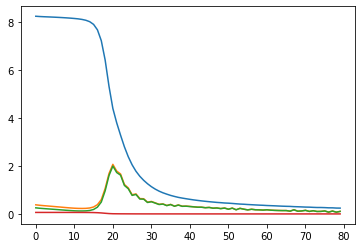

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.plot(history['val_fp_loss'])
plt.plot(history['val_fn_loss'])


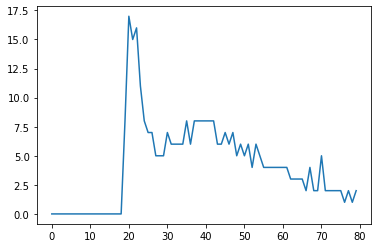

In [24]:
plt.plot(history['val_fp'])


In [25]:
%%bash
mkdir -p models/

In [26]:
yu_clf.save_weights('models/yu.hdf5')

## $z$ $sign flips$  Side-Channel Training

Each trace consists of 232 samples. Only the samples [30, 80] are of interest for the side-channel leakage.

In [27]:
training_z_cflip_data['trace'] = training_z_cflip_data.apply(lambda row: row['trace'][30:80], axis=1)
training_z_cflip_data['z<0'] = training_z_cflip_data['z'] < 0

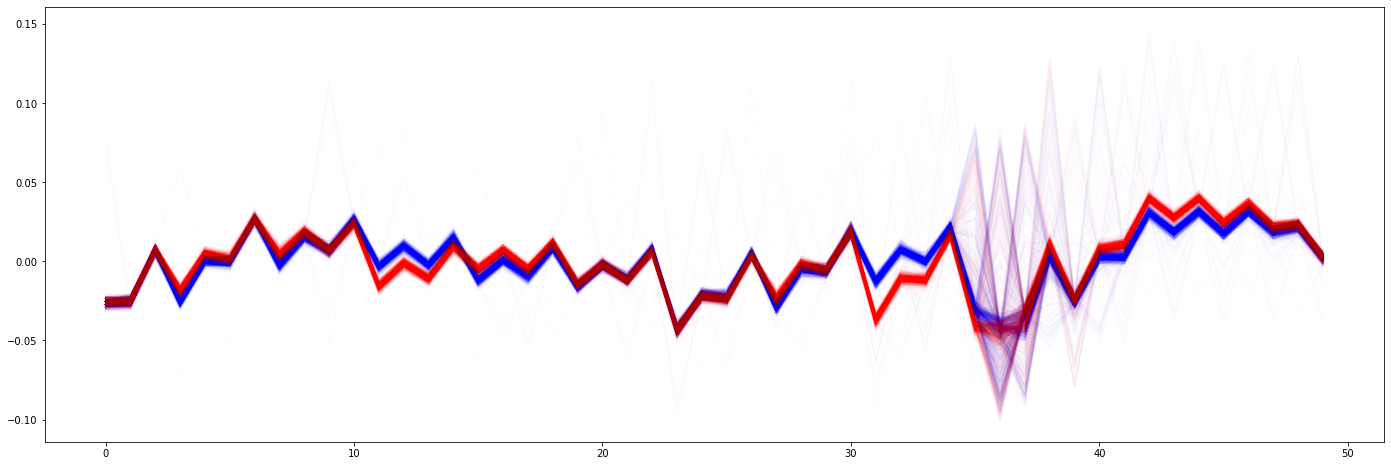

In [28]:
plt.figure(figsize=(24, 8))

for cf, zgdata in training_z_cflip_data.groupby(['z<0']): 
    for idx, row in zgdata[:1000].iterrows():   
        plt.plot(row['trace'], alpha=.01, color=('red' if cf else 'blue'))

In [29]:
training_z_cflip_data['status'] = 'train'
X_z_cflip_train = series_to_numpy(training_z_cflip_data[training_z_cflip_data['status'] == 'train']['trace'])
Y_z_cflip_train = training_z_cflip_data[training_z_cflip_data['status'] == 'train']['z<0'].to_numpy()
X_z_cflip_train = sklearn.preprocessing.StandardScaler().fit_transform(X_z_cflip_train)

Train $z$ $signflip$ classifier

In [30]:
z_cflip_clf = MLPClassifier(
    random_state=41,
    solver='adam', 
    learning_rate='adaptive',
    max_iter=200, 
    hidden_layer_sizes=[10],
    batch_size=500,
    early_stopping=True,
    n_iter_no_change=150,
    verbose=True,
)
z_cflip_clf.fit(X_z_cflip_train , Y_z_cflip_train)

Iteration 1, loss = 0.04291808
Validation score: 0.997664
Iteration 2, loss = 0.00572595
Validation score: 0.998813
Iteration 3, loss = 0.00321408
Validation score: 0.999349
Iteration 4, loss = 0.00206520
Validation score: 0.999694
Iteration 5, loss = 0.00147654
Validation score: 0.999809
Iteration 6, loss = 0.00112730
Validation score: 0.999809
Iteration 7, loss = 0.00090664
Validation score: 0.999847
Iteration 8, loss = 0.00074295
Validation score: 0.999847
Iteration 9, loss = 0.00061986
Validation score: 0.999885
Iteration 10, loss = 0.00052176
Validation score: 0.999923
Iteration 11, loss = 0.00043320
Validation score: 0.999962
Iteration 12, loss = 0.00036494
Validation score: 0.999923
Iteration 13, loss = 0.00030679
Validation score: 0.999923
Iteration 14, loss = 0.00025293
Validation score: 0.999923
Iteration 15, loss = 0.00021491
Validation score: 0.999962
Iteration 16, loss = 0.00018324
Validation score: 1.000000
Iteration 17, loss = 0.00014982
Validation score: 0.999962
Iterat

Iteration 140, loss = 0.00004002
Validation score: 1.000000
Iteration 141, loss = 0.00001953
Validation score: 1.000000
Iteration 142, loss = 0.00001276
Validation score: 1.000000
Iteration 143, loss = 0.00001230
Validation score: 1.000000
Iteration 144, loss = 0.00001206
Validation score: 1.000000
Iteration 145, loss = 0.00001188
Validation score: 1.000000
Iteration 146, loss = 0.00001172
Validation score: 1.000000
Iteration 147, loss = 0.00001158
Validation score: 1.000000
Iteration 148, loss = 0.00001147
Validation score: 1.000000
Iteration 149, loss = 0.00001132
Validation score: 1.000000
Iteration 150, loss = 0.00001120
Validation score: 1.000000
Iteration 151, loss = 0.00001109
Validation score: 1.000000
Iteration 152, loss = 0.00001098
Validation score: 1.000000
Iteration 153, loss = 0.00001089
Validation score: 1.000000
Iteration 154, loss = 0.00001083
Validation score: 1.000000
Iteration 155, loss = 0.00001449
Validation score: 0.999923
Iteration 156, loss = 0.00010023
Validat

MLPClassifier(batch_size=500, early_stopping=True, hidden_layer_sizes=[10],
              learning_rate='adaptive', n_iter_no_change=150, random_state=41,
              verbose=True)

## $sc$ $signflip$ Side-Channel Training

Each trace consists of 232 samples. Only the samples [30, 80] are of interest for the side-channel leakage.

In [31]:
training_sc_cflip_data['inputs'] = training_sc_cflip_data.apply(lambda row: np.array(row['inputs'], np.int32), axis=1)
training_sc_cflip_data['trace'] = training_sc_cflip_data.apply(lambda row: row['trace'][30:80], axis=1)
training_sc_cflip_data['b'] = training_sc_cflip_data.apply(lambda row: int(1- row['inputs'][1]%2), axis=1)

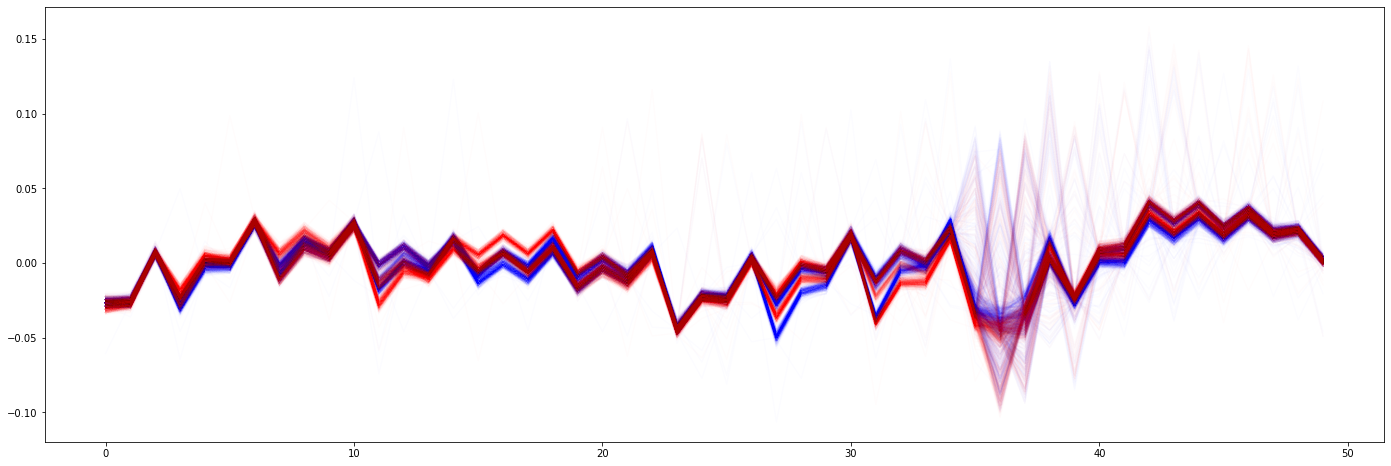

In [32]:
plt.figure(figsize=(24, 8))

for cf, scgdata in training_sc_cflip_data.groupby(['b']): 
    for idx, row in scgdata[:1000].iterrows():   
        plt.plot(row['trace'], alpha=.01, color=('red' if cf else 'blue'))

In [33]:
training_sc_cflip_data['status'] = 'train'
X_sc_cflip_train = series_to_numpy(training_sc_cflip_data[training_sc_cflip_data['status'] == 'train']['trace'])
Y_sc_cflip_train = training_sc_cflip_data[training_sc_cflip_data['status'] == 'train']['b'].to_numpy()
X_sc_cflip_train = sklearn.preprocessing.StandardScaler().fit_transform(X_sc_cflip_train)

Train $z$ $signflip$ classifier

In [34]:
sc_cflip_clf = MLPClassifier(
    random_state=41,
    solver='adam', 
    learning_rate='adaptive',
    max_iter=200, 
    hidden_layer_sizes=[10],
    batch_size=500,
    early_stopping=True,
    n_iter_no_change=150,
    verbose=True,
)
sc_cflip_clf.fit(X_sc_cflip_train , Y_sc_cflip_train)

Iteration 1, loss = 0.10109441
Validation score: 0.995175
Iteration 2, loss = 0.01731579
Validation score: 0.996477
Iteration 3, loss = 0.01188882
Validation score: 0.997051
Iteration 4, loss = 0.00911460
Validation score: 0.997511
Iteration 5, loss = 0.00714398
Validation score: 0.997970
Iteration 6, loss = 0.00561039
Validation score: 0.998200
Iteration 7, loss = 0.00447181
Validation score: 0.998545
Iteration 8, loss = 0.00366278
Validation score: 0.998813
Iteration 9, loss = 0.00310719
Validation score: 0.998775
Iteration 10, loss = 0.00269468
Validation score: 0.998813
Iteration 11, loss = 0.00239546
Validation score: 0.999004
Iteration 12, loss = 0.00214980
Validation score: 0.998851
Iteration 13, loss = 0.00197405
Validation score: 0.998966
Iteration 14, loss = 0.00179311
Validation score: 0.999043
Iteration 15, loss = 0.00164576
Validation score: 0.998966
Iteration 16, loss = 0.00150504
Validation score: 0.998966
Iteration 17, loss = 0.00140972
Validation score: 0.999157
Iterat

Iteration 140, loss = 0.00006199
Validation score: 0.999540
Iteration 141, loss = 0.00003466
Validation score: 0.999617
Iteration 142, loss = 0.00003036
Validation score: 0.999617
Iteration 143, loss = 0.00002955
Validation score: 0.999540
Iteration 144, loss = 0.00002905
Validation score: 0.999540
Iteration 145, loss = 0.00002865
Validation score: 0.999617
Iteration 146, loss = 0.00002819
Validation score: 0.999655
Iteration 147, loss = 0.00002840
Validation score: 0.999579
Iteration 148, loss = 0.00002964
Validation score: 0.999502
Iteration 149, loss = 0.00003108
Validation score: 0.999540
Iteration 150, loss = 0.00003129
Validation score: 0.999502
Iteration 151, loss = 0.00003452
Validation score: 0.999502
Iteration 152, loss = 0.00005501
Validation score: 0.999464
Iteration 153, loss = 0.00004496
Validation score: 0.999579
Iteration 154, loss = 0.00003368
Validation score: 0.999502
Iteration 155, loss = 0.00003037
Validation score: 0.999464
Iteration 156, loss = 0.00002809
Validat

MLPClassifier(batch_size=500, early_stopping=True, hidden_layer_sizes=[10],
              learning_rate='adaptive', n_iter_no_change=150, random_state=41,
              verbose=True)

In [35]:
with open('models/b.pickle', 'wb') as f:
    pickle.dump(sc_cflip_clf, f)

## 2.2) Attack Phase

Loading attack data

In [36]:
# This path has to be the path to the traced data after preprocessing
attack_data_path = DATA_PATH + "data_device_b_attack_1_2/"

In [37]:
attack_data = read_bliss_data(DATA_PATH, "data_device_b_attack_1_2")

In [38]:
# trunkcate to first half
for col in ['yu', 'Kx', 'z']:
    attack_data[col] = attack_data.apply(lambda row: row[col][:512], axis=1)

# filter b to relevant bit
attack_data['b'] = attack_data.apply(lambda row: 1 - (row['b'] % 2), axis=1)

#filter z to aquire a
attack_data['a'] = attack_data.apply(lambda row: np.sign(row['z']), axis=1)
attack_data['a'] = attack_data.apply(lambda row: np.where(row['a'] == -1, 1, 0), axis=1)

# Transpose C_matrix
attack_data['C_matrix'] = attack_data.apply(lambda row: row['C_matrix'].T, axis=1)
    
# compute corresponding trace index (discarding failed attempts)
attack_data['trace_idx'] = np.cumsum(attack_data['num_attempts']) - 1

In [39]:
# Loding the data
attack_kx_data = pd.read_pickle(attack_data_path + 'Kx_const_cw_data.pickle')
attack_yu_data = pd.read_pickle(attack_data_path + 'yu_cw_data.pickle')
attack_z_cflip_data = pd.read_pickle(attack_data_path + 'z_cflip_cw_data.pickle')
attack_sc_cflip_data = pd.read_pickle(attack_data_path + 'sc_cflip_cw_data.pickle')

In [40]:
attack_kx_data.reset_index(inplace=True)
attack_yu_data.reset_index(inplace=True)
attack_z_cflip_data.reset_index(inplace=True)
attack_sc_cflip_data.reset_index(inplace=True)

Predicting $Kx$ using the classifier from the profiling phase

In [41]:
attack_kx_data['trace'] = attack_kx_data.apply(lambda row: row['trace'][1890:1920], axis=1)
attack_kx_data['status'] = 'train'
attack_kx_data['prediction'] = kx_clf.predict(sklearn.preprocessing.StandardScaler().fit_transform(series_to_numpy(attack_kx_data['trace'])))

In [42]:
np.average(attack_kx_data['Kx'] == attack_kx_data['prediction'])

0.930358318240287

Predicting $yu$ using the classifier from the profiling phase

In [43]:
attack_yu_data['yu=0'] = attack_yu_data['yu'] == 0
attack_yu_data['trace'] = attack_yu_data.apply(lambda row: row['trace'][85:110], axis=1)
attack_yu_traces = series_to_numpy(attack_yu_data['trace'])
attack_yu_traces = sklearn.preprocessing.StandardScaler().fit_transform(attack_yu_traces)
attack_yu_data['prediction_p'] = yu_clf.predict(attack_yu_traces, batch_size=1000)[:, 0]
attack_yu_data['prediction'] = np.round(attack_yu_data['prediction_p']) == 1

In [44]:
np.average(attack_yu_data['yu=0'] == attack_yu_data['prediction'])

0.9995249887624337

In [45]:
print('total number', len(attack_yu_data))
print('false positives: ', sum(attack_yu_data['prediction'] & ~attack_yu_data['yu=0']))
print('false negatives: ', sum(~attack_yu_data['prediction'] & attack_yu_data['yu=0']))
print('accuracy', sum(attack_yu_data['prediction'] == attack_yu_data['yu=0']) / len(attack_yu_data))

total number 1450492
false positives:  15
false negatives:  674
accuracy 0.9995249887624337


Predicting $z\_cflip$ using the classifier from the profiling phase

In [46]:
attack_z_cflip_data['trace'] = attack_z_cflip_data.apply(lambda row: row['trace'][30:80], axis=1)
attack_z_cflip_data['z<0'] = attack_z_cflip_data['z'] < 0
attack_z_cflip_data['prediction'] = z_cflip_clf.predict(sklearn.preprocessing.StandardScaler().fit_transform(series_to_numpy(attack_z_cflip_data['trace'])))

In [47]:
np.average(attack_z_cflip_data['z<0'] == attack_z_cflip_data['prediction'])

0.9997375757158591

Predicting $sc\_cflip$ using the classifier from the profiling phase

In [48]:
attack_sc_cflip_data['inputs'] = attack_sc_cflip_data.apply(lambda row: np.array(row['inputs'], np.int32), axis=1)
attack_sc_cflip_data['trace'] = attack_sc_cflip_data.apply(lambda row: row['trace'][30:80], axis=1)
attack_sc_cflip_data['b'] = attack_sc_cflip_data.apply(lambda row: int(1- row['inputs'][1]%2), axis=1)
attack_sc_cflip_data['prediction'] = sc_cflip_clf.predict(sklearn.preprocessing.StandardScaler().fit_transform(series_to_numpy(attack_sc_cflip_data['trace'])))

In [49]:
np.average(attack_sc_cflip_data['b'] == attack_sc_cflip_data['prediction'])

0.999350392345815

Attack all side-channels using the classifier

In [50]:
YU_FALSE_POS = set()

def get_prediction(ti, db, fill_gaps=None):
    p = {}
    data = db[db['sign_num'] == ti].sort_values('index')
    assert len(data) > 0, f'Could not find predictions for trace index {ti}'
    for i, row in data.iterrows():
        p[row['index']] = row['prediction']
        
    if fill_gaps is not None and p.keys() != set(range(512)):
        gaps = set(range(512)) - p.keys()
        for i in gaps:
            p[i] = fill_gaps
        
    return np.array([p[key] for key in sorted(p)])

def attack_z(row):
    ti = row['trace_idx'] 
    
    p = get_prediction(ti, attack_z_cflip_data)
    if len(p) < 512:
        print(f'cflip data for trace index {ti} incomplete!')
    return p

def attack_kx(row):
    ti = row['trace_idx'] 
    
    p = get_prediction(ti, attack_kx_data, fill_gaps=0)
    if len(p) < 512:
        p = np.append(p, 0)
    p *= attack_z(row)
    return p
    
def attack_b(row):
    ti = row.name
    
    p = get_prediction(ti, attack_sc_cflip_data)
    if len(p) < 512:
        print(f'cflip data for trace index {ti} incomplete!')
    p = int(p[0])
    return p

def attack_yu(trace):
    ti = row['trace_idx'] 
    p = get_prediction(ti, attack_yu_data, fill_gaps=False)
    t = row['yu'] == 0
    
    if len(p) != 512:
        print(f'yu {ti=} {len(p)=}')
    
    if sum(~t & p):
        YU_FALSE_POS.add(ti)
        print(f'Trace index {ti} has {sum(~t & p)} false positives for yu=0!')

    return p

### Attack using Moore-Penrose Inverse

In [51]:
LHS = []
RHS = []
SCRHS = []
KX = []
SCKX = []
FP = []

yu_zero_counter = 0

gdata = attack_z_cflip_data.groupby('sign_num').count()
FAULTY_TRACES_Z = set((gdata[gdata['under_attack'] < 512]).index)

# iterate over traces
for j, row in attack_data[attack_data['trace_idx'].isin(range(len(set(np.unique(attack_kx_data['sign_num']))))) & ~attack_data['trace_idx'].isin(FAULTY_TRACES_Z)].iterrows():
    
    # recover Kx and b using our ML attacks
    row['Kx_recovered'] = attack_kx(row)
    if row['Kx_recovered'] is None:
        print('skip')
        continue

    row['b_recovered'] = attack_b(row)
    row['yu_eq_zero_recovered'] = attack_yu(row)
    
    # iterate over elements of the vectors
    for i, yu_eq_zero in enumerate(row['yu_eq_zero_recovered']):
        if yu_eq_zero:  # we have a side-channel for this
            yu_zero_counter += 1
            if row['yu'][i] != 0:
                print(f"False pos for {row['trace_idx']} at index {i}: actual: {row['yu'][i]} prediction: {row['yu_eq_zero_recovered'][i]}")
                FP.append(len(RHS))

            # data we use
            C = row['C_matrix']  # C is a function of the challenge c, not only public but also attacker-chosen
            z = row['z1'][i]  # public as part of the signature

            SC_Kx = row['Kx_recovered'][i]
            Kx = row['Kx'][i]
            b = row['b_recovered']
            
            rhs = (z - Kx)/((-1)**b) % 256
            if rhs > 128:
                rhs -= 256
                
            scrhs = (z - SC_Kx)/((-1)**b) % 256
            if scrhs > 128:
                scrhs -= 256
            
            lhs = C[:, i]
            
            RHS.append(rhs)
            SCRHS.append(scrhs)
            LHS.append(lhs)
            
            KX.append(Kx)
            SCKX.append(SC_Kx)
              
LHS, RHS, SCRHS = np.array(LHS), np.array(RHS), np.array(SCRHS)
our_s = np.linalg.pinv(LHS) @ RHS
sc_our_s = np.linalg.pinv(LHS) @ SCRHS
real_s = attack_data.iloc[0]['s1']

np.average(np.around(our_s) == real_s), np.average(np.around(sc_our_s) == real_s)

Trace index 187 has 1 false positives for yu=0!
False pos for 187 at index 9: actual: 3 prediction: True
Trace index 368 has 1 false positives for yu=0!
False pos for 368 at index 224: actual: 6 prediction: True
Trace index 385 has 1 false positives for yu=0!
False pos for 385 at index 416: actual: 2 prediction: True


(1.0, 1.0)

In [52]:
resultpenrose = []

for seed in range(5):
    for size in [10, 50, 200, 240, 256, 280, 300, 350, 400, 450, 500, 512, 520, 530, 540, 550, 600, len(RHS)]:
        rss = np.random.default_rng(seed).choice(range(len(RHS)), size=size, replace=False)
        included_fp = len(set(rss) & set(FP))
        
        for removed_fp in range(included_fp + 1):
            rm_fp = np.random.default_rng(seed).choice(list(set(rss) & set(FP)), size=removed_fp, replace=False)
            rss1 = list(set(rss) - set(rm_fp))
            rss_sc_our_s = np.linalg.pinv(LHS[rss1]) @ SCRHS[rss1]
            real_s = attack_data.iloc[0]['s1']

            acc = np.average(np.around(rss_sc_our_s) == real_s)
            corr = sp.stats.pearsonr(rss_sc_our_s, real_s)[0]

            resultpenrose.append({
                'accuracy': acc,
                'correlation': corr,
                'included_fp': included_fp,
                'removed_fp': removed_fp,
                'total_fp': included_fp - removed_fp,
                'size': len(rss1),
                'seed': seed,
            })
        
resultpenrose = pd.DataFrame(resultpenrose)

### Attack using ML

In [53]:
mlresult = []

for seed in range(5):
    for size in [10, 50, 200, 240, 256, 280, 300, 350, 400, 450, 500, 512, 520, 530, 540, 550, 600, len(RHS)]:
        rss = np.random.default_rng(seed).choice(range(len(RHS)), size=size, replace=False)
        included_fp = len(set(rss) & set(FP))
        
        for removed_fp in range(included_fp + 1):
            rm_fp = np.random.default_rng(seed).choice(list(set(rss) & set(FP)), size=removed_fp, replace=False)
            rss1 = list(set(rss) - set(rm_fp))
            
            
            tf.random.set_seed(1)
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False,))
            opt = tf.keras.optimizers.Adam(learning_rate=.01)
            model.build(input_shape=(None, 512))
            model.compile(optimizer=opt, loss='mse')
            model.fit(LHS[rss1], RHS[rss1], epochs=40, batch_size=0, validation_split=0)
            rss_sc_our_s = model.weights[0].numpy()[:, 0]
            
            
            real_s = training_data.iloc[0]['s1']

            acc = np.average(np.around(rss_sc_our_s) == real_s)
            corr = sp.stats.pearsonr(rss_sc_our_s, real_s)[0]

            mlresult.append({
                'accuracy': acc,
                'correlation': corr,
                'included_fp': included_fp,
                'removed_fp': removed_fp,
                'total_fp': included_fp - removed_fp,
                'size': len(rss1),
                'seed': seed,
            })
        
mlresult = pd.DataFrame(mlresult)

Epoch 1/40
1/1 [==============================] - 0s 177ms/step - loss: 6.3382
Epoch 2/40
1/1 [==============================] - 0s 3ms/step - loss: 5.5657
Epoch 3/40
1/1 [==============================] - 0s 2ms/step - loss: 4.8692
Epoch 4/40
1/1 [==============================] - 0s 2ms/step - loss: 4.2437
Epoch 5/40
1/1 [==============================] - 0s 2ms/step - loss: 3.6823
Epoch 6/40
1/1 [==============================] - 0s 1ms/step - loss: 3.1813
Epoch 7/40
1/1 [==============================] - 0s 1ms/step - loss: 2.7382
Epoch 8/40
1/1 [==============================] - 0s 1ms/step - loss: 2.3507
Epoch 9/40
1/1 [==============================] - 0s 1ms/step - loss: 2.0152
Epoch 10/40
1/1 [==============================] - 0s 2ms/step - loss: 1.7265
Epoch 11/40
1/1 [==============================] - 0s 2ms/step - loss: 1.4793
Epoch 12/40
1/1 [==============================] - 0s 1ms/step - loss: 1.2683
Epoch 13/40
1/1 [==============================] - 0s 1ms/step - loss: 

7/7 [==============================] - 0s 683us/step - loss: 0.1716
Epoch 26/40
7/7 [==============================] - 0s 782us/step - loss: 0.1542
Epoch 27/40
7/7 [==============================] - 0s 769us/step - loss: 0.1351
Epoch 28/40
7/7 [==============================] - 0s 752us/step - loss: 0.1208
Epoch 29/40
7/7 [==============================] - 0s 816us/step - loss: 0.1084
Epoch 30/40
7/7 [==============================] - 0s 750us/step - loss: 0.0970
Epoch 31/40
7/7 [==============================] - 0s 652us/step - loss: 0.0868
Epoch 32/40
7/7 [==============================] - 0s 809us/step - loss: 0.0779
Epoch 33/40
7/7 [==============================] - 0s 798us/step - loss: 0.0697
Epoch 34/40
7/7 [==============================] - 0s 789us/step - loss: 0.0622
Epoch 35/40
7/7 [==============================] - 0s 856us/step - loss: 0.0558
Epoch 36/40
7/7 [==============================] - 0s 757us/step - loss: 0.0503
Epoch 37/40
7/7 [==============================] - 0

Epoch 8/40
8/8 [==============================] - 0s 667us/step - loss: 1.6670
Epoch 9/40
8/8 [==============================] - 0s 723us/step - loss: 1.3960
Epoch 10/40
8/8 [==============================] - 0s 730us/step - loss: 1.1756
Epoch 11/40
8/8 [==============================] - 0s 725us/step - loss: 0.9960
Epoch 12/40
8/8 [==============================] - 0s 698us/step - loss: 0.8453
Epoch 13/40
8/8 [==============================] - 0s 669us/step - loss: 0.7215
Epoch 14/40
8/8 [==============================] - 0s 748us/step - loss: 0.6195
Epoch 15/40
8/8 [==============================] - 0s 787us/step - loss: 0.5369
Epoch 16/40
8/8 [==============================] - 0s 741us/step - loss: 0.4604
Epoch 17/40
8/8 [==============================] - 0s 733us/step - loss: 0.3965
Epoch 18/40
8/8 [==============================] - 0s 667us/step - loss: 0.3482
Epoch 19/40
8/8 [==============================] - 0s 799us/step - loss: 0.3058
Epoch 20/40
8/8 [=========================

8/8 [==============================] - 0s 780us/step - loss: 0.0870
Epoch 31/40
8/8 [==============================] - 0s 747us/step - loss: 0.0787
Epoch 32/40
8/8 [==============================] - 0s 689us/step - loss: 0.0710
Epoch 33/40
8/8 [==============================] - 0s 700us/step - loss: 0.0651
Epoch 34/40
8/8 [==============================] - 0s 733us/step - loss: 0.0593
Epoch 35/40
8/8 [==============================] - 0s 715us/step - loss: 0.0543
Epoch 36/40
8/8 [==============================] - 0s 819us/step - loss: 0.0496
Epoch 37/40
8/8 [==============================] - 0s 770us/step - loss: 0.0454
Epoch 38/40
8/8 [==============================] - 0s 723us/step - loss: 0.0415
Epoch 39/40
8/8 [==============================] - 0s 721us/step - loss: 0.0377
Epoch 40/40
8/8 [==============================] - 0s 776us/step - loss: 0.0348
Epoch 1/40
8/8 [==============================] - 0s 1ms/step - loss: 6.1891
Epoch 2/40
8/8 [==============================] - 0s 77

Epoch 13/40
9/9 [==============================] - 0s 758us/step - loss: 0.7625
Epoch 14/40
9/9 [==============================] - 0s 741us/step - loss: 0.6592
Epoch 15/40
9/9 [==============================] - 0s 693us/step - loss: 0.5737
Epoch 16/40
9/9 [==============================] - 0s 737us/step - loss: 0.5026
Epoch 17/40
9/9 [==============================] - 0s 754us/step - loss: 0.4388
Epoch 18/40
9/9 [==============================] - 0s 701us/step - loss: 0.3881
Epoch 19/40
9/9 [==============================] - 0s 801us/step - loss: 0.3417
Epoch 20/40
9/9 [==============================] - 0s 841us/step - loss: 0.3016
Epoch 21/40
9/9 [==============================] - 0s 771us/step - loss: 0.2685
Epoch 22/40
9/9 [==============================] - 0s 785us/step - loss: 0.2396
Epoch 23/40
9/9 [==============================] - 0s 761us/step - loss: 0.2122
Epoch 24/40
9/9 [==============================] - 0s 820us/step - loss: 0.1923
Epoch 25/40
9/9 [=======================

11/11 [==============================] - 0s 708us/step - loss: 0.0762
Epoch 34/40
11/11 [==============================] - 0s 709us/step - loss: 0.0703
Epoch 35/40
11/11 [==============================] - 0s 681us/step - loss: 0.0649
Epoch 36/40
11/11 [==============================] - 0s 610us/step - loss: 0.0603
Epoch 37/40
11/11 [==============================] - 0s 576us/step - loss: 0.0563
Epoch 38/40
11/11 [==============================] - 0s 663us/step - loss: 0.0521
Epoch 39/40
11/11 [==============================] - 0s 729us/step - loss: 0.0487
Epoch 40/40
11/11 [==============================] - 0s 775us/step - loss: 0.0449
Epoch 1/40
11/11 [==============================] - 0s 927us/step - loss: 5.8436
Epoch 2/40
11/11 [==============================] - 0s 720us/step - loss: 4.5009
Epoch 3/40
11/11 [==============================] - 0s 730us/step - loss: 3.5611
Epoch 4/40
11/11 [==============================] - 0s 794us/step - loss: 2.8724
Epoch 5/40
11/11 [==============

11/11 [==============================] - 0s 730us/step - loss: 0.5526
Epoch 14/40
11/11 [==============================] - 0s 731us/step - loss: 0.4764
Epoch 15/40
11/11 [==============================] - 0s 752us/step - loss: 0.4170
Epoch 16/40
11/11 [==============================] - 0s 765us/step - loss: 0.3660
Epoch 17/40
11/11 [==============================] - 0s 754us/step - loss: 0.3223
Epoch 18/40
11/11 [==============================] - 0s 731us/step - loss: 0.2825
Epoch 19/40
11/11 [==============================] - 0s 703us/step - loss: 0.2520
Epoch 20/40
11/11 [==============================] - 0s 693us/step - loss: 0.2253
Epoch 21/40
11/11 [==============================] - 0s 705us/step - loss: 0.2003
Epoch 22/40
11/11 [==============================] - 0s 759us/step - loss: 0.1790
Epoch 23/40
11/11 [==============================] - 0s 757us/step - loss: 0.1612
Epoch 24/40
11/11 [==============================] - 0s 821us/step - loss: 0.1460
Epoch 25/40
11/11 [=========

13/13 [==============================] - 0s 706us/step - loss: 0.0715
Epoch 34/40
13/13 [==============================] - 0s 767us/step - loss: 0.0672
Epoch 35/40
13/13 [==============================] - 0s 756us/step - loss: 0.0623
Epoch 36/40
13/13 [==============================] - 0s 710us/step - loss: 0.0585
Epoch 37/40
13/13 [==============================] - 0s 691us/step - loss: 0.0549
Epoch 38/40
13/13 [==============================] - 0s 754us/step - loss: 0.0511
Epoch 39/40
13/13 [==============================] - 0s 708us/step - loss: 0.0480
Epoch 40/40
13/13 [==============================] - 0s 747us/step - loss: 0.0448
Epoch 1/40
13/13 [==============================] - 0s 858us/step - loss: 6.7399
Epoch 2/40
13/13 [==============================] - 0s 709us/step - loss: 5.1230
Epoch 3/40
13/13 [==============================] - 0s 731us/step - loss: 4.0727
Epoch 4/40
13/13 [==============================] - 0s 737us/step - loss: 3.2527
Epoch 5/40
13/13 [==============

15/15 [==============================] - 0s 689us/step - loss: 0.7484
Epoch 14/40
15/15 [==============================] - 0s 690us/step - loss: 0.6761
Epoch 15/40
15/15 [==============================] - 0s 704us/step - loss: 0.6086
Epoch 16/40
15/15 [==============================] - 0s 724us/step - loss: 0.5492
Epoch 17/40
15/15 [==============================] - 0s 725us/step - loss: 0.5013
Epoch 18/40
15/15 [==============================] - 0s 716us/step - loss: 0.4612
Epoch 19/40
15/15 [==============================] - 0s 754us/step - loss: 0.4229
Epoch 20/40
15/15 [==============================] - 0s 677us/step - loss: 0.3926
Epoch 21/40
15/15 [==============================] - 0s 679us/step - loss: 0.3694
Epoch 22/40
15/15 [==============================] - 0s 636us/step - loss: 0.3439
Epoch 23/40
15/15 [==============================] - 0s 687us/step - loss: 0.3230
Epoch 24/40
15/15 [==============================] - 0s 649us/step - loss: 0.3128
Epoch 25/40
15/15 [=========

14/14 [==============================] - 0s 742us/step - loss: 0.0784
Epoch 34/40
14/14 [==============================] - 0s 716us/step - loss: 0.0733
Epoch 35/40
14/14 [==============================] - 0s 687us/step - loss: 0.0683
Epoch 36/40
14/14 [==============================] - 0s 746us/step - loss: 0.0640
Epoch 37/40
14/14 [==============================] - 0s 721us/step - loss: 0.0598
Epoch 38/40
14/14 [==============================] - 0s 788us/step - loss: 0.0567
Epoch 39/40
14/14 [==============================] - 0s 607us/step - loss: 0.0531
Epoch 40/40
14/14 [==============================] - 0s 692us/step - loss: 0.0500
Epoch 1/40
16/16 [==============================] - 0s 908us/step - loss: 6.3204
Epoch 2/40
16/16 [==============================] - 0s 757us/step - loss: 4.7715
Epoch 3/40
16/16 [==============================] - 0s 711us/step - loss: 3.7633
Epoch 4/40
16/16 [==============================] - 0s 721us/step - loss: 2.9461
Epoch 5/40
16/16 [==============

16/16 [==============================] - 0s 690us/step - loss: 0.5381
Epoch 14/40
16/16 [==============================] - 0s 722us/step - loss: 0.4628
Epoch 15/40
16/16 [==============================] - 0s 718us/step - loss: 0.4021
Epoch 16/40
16/16 [==============================] - 0s 705us/step - loss: 0.3555
Epoch 17/40
16/16 [==============================] - 0s 712us/step - loss: 0.3096
Epoch 18/40
16/16 [==============================] - 0s 743us/step - loss: 0.2744
Epoch 19/40
16/16 [==============================] - 0s 716us/step - loss: 0.2452
Epoch 20/40
16/16 [==============================] - 0s 735us/step - loss: 0.2211
Epoch 21/40
16/16 [==============================] - 0s 732us/step - loss: 0.1972
Epoch 22/40
16/16 [==============================] - 0s 730us/step - loss: 0.1795
Epoch 23/40
16/16 [==============================] - 0s 704us/step - loss: 0.1623
Epoch 24/40
16/16 [==============================] - 0s 733us/step - loss: 0.1476
Epoch 25/40
16/16 [=========

16/16 [==============================] - 0s 722us/step - loss: 0.0781
Epoch 34/40
16/16 [==============================] - 0s 669us/step - loss: 0.0741
Epoch 35/40
16/16 [==============================] - 0s 701us/step - loss: 0.0694
Epoch 36/40
16/16 [==============================] - 0s 721us/step - loss: 0.0658
Epoch 37/40
16/16 [==============================] - 0s 681us/step - loss: 0.0622
Epoch 38/40
16/16 [==============================] - 0s 701us/step - loss: 0.0594
Epoch 39/40
16/16 [==============================] - 0s 758us/step - loss: 0.0565
Epoch 40/40
16/16 [==============================] - 0s 681us/step - loss: 0.0539
Epoch 1/40
16/16 [==============================] - 0s 888us/step - loss: 6.2531
Epoch 2/40
16/16 [==============================] - 0s 744us/step - loss: 4.7551
Epoch 3/40
16/16 [==============================] - 0s 688us/step - loss: 3.6809
Epoch 4/40
16/16 [==============================] - 0s 674us/step - loss: 2.8917
Epoch 5/40
16/16 [==============

17/17 [==============================] - 0s 758us/step - loss: 0.5609
Epoch 14/40
17/17 [==============================] - 0s 777us/step - loss: 0.4865
Epoch 15/40
17/17 [==============================] - 0s 720us/step - loss: 0.4230
Epoch 16/40
17/17 [==============================] - 0s 710us/step - loss: 0.3723
Epoch 17/40
17/17 [==============================] - 0s 772us/step - loss: 0.3291
Epoch 18/40
17/17 [==============================] - 0s 681us/step - loss: 0.2932
Epoch 19/40
17/17 [==============================] - 0s 751us/step - loss: 0.2633
Epoch 20/40
17/17 [==============================] - 0s 749us/step - loss: 0.2344
Epoch 21/40
17/17 [==============================] - 0s 704us/step - loss: 0.2108
Epoch 22/40
17/17 [==============================] - 0s 680us/step - loss: 0.1929
Epoch 23/40
17/17 [==============================] - 0s 755us/step - loss: 0.1747
Epoch 24/40
17/17 [==============================] - 0s 757us/step - loss: 0.1600
Epoch 25/40
17/17 [=========

17/17 [==============================] - 0s 787us/step - loss: 0.0808
Epoch 34/40
17/17 [==============================] - 0s 743us/step - loss: 0.0747
Epoch 35/40
17/17 [==============================] - 0s 747us/step - loss: 0.0697
Epoch 36/40
17/17 [==============================] - 0s 715us/step - loss: 0.0653
Epoch 37/40
17/17 [==============================] - 0s 702us/step - loss: 0.0622
Epoch 38/40
17/17 [==============================] - 0s 746us/step - loss: 0.0584
Epoch 39/40
17/17 [==============================] - 0s 735us/step - loss: 0.0547
Epoch 40/40
17/17 [==============================] - 0s 773us/step - loss: 0.0519
Epoch 1/40
17/17 [==============================] - 0s 893us/step - loss: 6.4072
Epoch 2/40
17/17 [==============================] - 0s 724us/step - loss: 4.7903
Epoch 3/40
17/17 [==============================] - 0s 667us/step - loss: 3.7317
Epoch 4/40
17/17 [==============================] - 0s 795us/step - loss: 2.9128
Epoch 5/40
17/17 [==============

17/17 [==============================] - 0s 742us/step - loss: 0.5221
Epoch 14/40
17/17 [==============================] - 0s 661us/step - loss: 0.4526
Epoch 15/40
17/17 [==============================] - 0s 685us/step - loss: 0.3966
Epoch 16/40
17/17 [==============================] - 0s 723us/step - loss: 0.3500
Epoch 17/40
17/17 [==============================] - 0s 788us/step - loss: 0.3067
Epoch 18/40
17/17 [==============================] - 0s 724us/step - loss: 0.2743
Epoch 19/40
17/17 [==============================] - 0s 719us/step - loss: 0.2442
Epoch 20/40
17/17 [==============================] - 0s 707us/step - loss: 0.2200
Epoch 21/40
17/17 [==============================] - 0s 715us/step - loss: 0.2003
Epoch 22/40
17/17 [==============================] - 0s 675us/step - loss: 0.1823
Epoch 23/40
17/17 [==============================] - 0s 711us/step - loss: 0.1648
Epoch 24/40
17/17 [==============================] - 0s 731us/step - loss: 0.1503
Epoch 25/40
17/17 [=========

17/17 [==============================] - 0s 695us/step - loss: 0.0952
Epoch 34/40
17/17 [==============================] - 0s 701us/step - loss: 0.0898
Epoch 35/40
17/17 [==============================] - 0s 699us/step - loss: 0.0855
Epoch 36/40
17/17 [==============================] - 0s 732us/step - loss: 0.0812
Epoch 37/40
17/17 [==============================] - 0s 756us/step - loss: 0.0775
Epoch 38/40
17/17 [==============================] - 0s 699us/step - loss: 0.0729
Epoch 39/40
17/17 [==============================] - 0s 663us/step - loss: 0.0702
Epoch 40/40
17/17 [==============================] - 0s 742us/step - loss: 0.0672
Epoch 1/40
17/17 [==============================] - 0s 875us/step - loss: 6.5532
Epoch 2/40
17/17 [==============================] - 0s 715us/step - loss: 4.8570
Epoch 3/40
17/17 [==============================] - 0s 710us/step - loss: 3.7450
Epoch 4/40
17/17 [==============================] - 0s 705us/step - loss: 2.9167
Epoch 5/40
17/17 [==============

17/17 [==============================] - 0s 756us/step - loss: 0.4963
Epoch 14/40
17/17 [==============================] - 0s 658us/step - loss: 0.4299
Epoch 15/40
17/17 [==============================] - 0s 779us/step - loss: 0.3739
Epoch 16/40
17/17 [==============================] - 0s 717us/step - loss: 0.3286
Epoch 17/40
17/17 [==============================] - 0s 705us/step - loss: 0.2898
Epoch 18/40
17/17 [==============================] - 0s 667us/step - loss: 0.2587
Epoch 19/40
17/17 [==============================] - 0s 670us/step - loss: 0.2326
Epoch 20/40
17/17 [==============================] - 0s 757us/step - loss: 0.2077
Epoch 21/40
17/17 [==============================] - 0s 701us/step - loss: 0.1878
Epoch 22/40
17/17 [==============================] - 0s 732us/step - loss: 0.1709
Epoch 23/40
17/17 [==============================] - 0s 746us/step - loss: 0.1560
Epoch 24/40
17/17 [==============================] - 0s 697us/step - loss: 0.1433
Epoch 25/40
17/17 [=========

18/18 [==============================] - 0s 653us/step - loss: 0.0881
Epoch 34/40
18/18 [==============================] - 0s 709us/step - loss: 0.0821
Epoch 35/40
18/18 [==============================] - 0s 702us/step - loss: 0.0786
Epoch 36/40
18/18 [==============================] - 0s 680us/step - loss: 0.0745
Epoch 37/40
18/18 [==============================] - 0s 666us/step - loss: 0.0700
Epoch 38/40
18/18 [==============================] - 0s 703us/step - loss: 0.0666
Epoch 39/40
18/18 [==============================] - 0s 651us/step - loss: 0.0617
Epoch 40/40
18/18 [==============================] - 0s 693us/step - loss: 0.0594
Epoch 1/40
18/18 [==============================] - 0s 859us/step - loss: 6.3744
Epoch 2/40
18/18 [==============================] - 0s 833us/step - loss: 4.7223
Epoch 3/40
18/18 [==============================] - 0s 701us/step - loss: 3.6905
Epoch 4/40
18/18 [==============================] - 0s 703us/step - loss: 2.8845
Epoch 5/40
18/18 [==============

19/19 [==============================] - 0s 774us/step - loss: 0.4742
Epoch 14/40
19/19 [==============================] - 0s 713us/step - loss: 0.4123
Epoch 15/40
19/19 [==============================] - 0s 737us/step - loss: 0.3637
Epoch 16/40
19/19 [==============================] - 0s 697us/step - loss: 0.3223
Epoch 17/40
19/19 [==============================] - 0s 693us/step - loss: 0.2870
Epoch 18/40
19/19 [==============================] - 0s 695us/step - loss: 0.2607
Epoch 19/40
19/19 [==============================] - 0s 735us/step - loss: 0.2339
Epoch 20/40
19/19 [==============================] - 0s 701us/step - loss: 0.2128
Epoch 21/40
19/19 [==============================] - 0s 708us/step - loss: 0.1951
Epoch 22/40
19/19 [==============================] - 0s 722us/step - loss: 0.1803
Epoch 23/40
19/19 [==============================] - 0s 775us/step - loss: 0.1659
Epoch 24/40
19/19 [==============================] - 0s 731us/step - loss: 0.1530
Epoch 25/40
19/19 [=========

19/19 [==============================] - 0s 777us/step - loss: 0.0610
Epoch 34/40
19/19 [==============================] - 0s 701us/step - loss: 0.0570
Epoch 35/40
19/19 [==============================] - 0s 712us/step - loss: 0.0532
Epoch 36/40
19/19 [==============================] - 0s 727us/step - loss: 0.0498
Epoch 37/40
19/19 [==============================] - 0s 725us/step - loss: 0.0466
Epoch 38/40
19/19 [==============================] - 0s 709us/step - loss: 0.0439
Epoch 39/40
19/19 [==============================] - 0s 711us/step - loss: 0.0411
Epoch 40/40
19/19 [==============================] - 0s 698us/step - loss: 0.0387
Epoch 1/40
19/19 [==============================] - 0s 850us/step - loss: 6.2013
Epoch 2/40
19/19 [==============================] - 0s 782us/step - loss: 4.5395
Epoch 3/40
19/19 [==============================] - 0s 678us/step - loss: 3.4542
Epoch 4/40
19/19 [==============================] - 0s 697us/step - loss: 2.6420
Epoch 5/40
19/19 [==============

20/20 [==============================] - 0s 708us/step - loss: 0.4898
Epoch 14/40
20/20 [==============================] - 0s 647us/step - loss: 0.4270
Epoch 15/40
20/20 [==============================] - 0s 742us/step - loss: 0.3732
Epoch 16/40
20/20 [==============================] - 0s 738us/step - loss: 0.3307
Epoch 17/40
20/20 [==============================] - 0s 692us/step - loss: 0.2990
Epoch 18/40
20/20 [==============================] - 0s 682us/step - loss: 0.2669
Epoch 19/40
20/20 [==============================] - 0s 717us/step - loss: 0.2419
Epoch 20/40
20/20 [==============================] - 0s 704us/step - loss: 0.2199
Epoch 21/40
20/20 [==============================] - 0s 692us/step - loss: 0.1999
Epoch 22/40
20/20 [==============================] - 0s 728us/step - loss: 0.1792
Epoch 23/40
20/20 [==============================] - 0s 736us/step - loss: 0.1640
Epoch 24/40
20/20 [==============================] - 0s 693us/step - loss: 0.1496
Epoch 25/40
20/20 [=========

20/20 [==============================] - 0s 670us/step - loss: 0.1231
Epoch 34/40
20/20 [==============================] - 0s 679us/step - loss: 0.1143
Epoch 35/40
20/20 [==============================] - 0s 707us/step - loss: 0.1153
Epoch 36/40
20/20 [==============================] - 0s 708us/step - loss: 0.1203
Epoch 37/40
20/20 [==============================] - 0s 684us/step - loss: 0.1109
Epoch 38/40
20/20 [==============================] - 0s 682us/step - loss: 0.1000
Epoch 39/40
20/20 [==============================] - 0s 685us/step - loss: 0.0924
Epoch 40/40
20/20 [==============================] - 0s 659us/step - loss: 0.0880
Epoch 1/40
1/1 [==============================] - 0s 158ms/step - loss: 5.6222
Epoch 2/40
1/1 [==============================] - 0s 3ms/step - loss: 4.8177
Epoch 3/40
1/1 [==============================] - 0s 2ms/step - loss: 4.0939
Epoch 4/40
1/1 [==============================] - 0s 2ms/step - loss: 3.4445
Epoch 5/40
1/1 [==============================

7/7 [==============================] - 0s 737us/step - loss: 0.3541
Epoch 18/40
7/7 [==============================] - 0s 809us/step - loss: 0.3099
Epoch 19/40
7/7 [==============================] - 0s 728us/step - loss: 0.2643
Epoch 20/40
7/7 [==============================] - 0s 711us/step - loss: 0.2296
Epoch 21/40
7/7 [==============================] - 0s 711us/step - loss: 0.1998
Epoch 22/40
7/7 [==============================] - 0s 795us/step - loss: 0.1767
Epoch 23/40
7/7 [==============================] - 0s 696us/step - loss: 0.1541
Epoch 24/40
7/7 [==============================] - 0s 733us/step - loss: 0.1333
Epoch 25/40
7/7 [==============================] - 0s 851us/step - loss: 0.1186
Epoch 26/40
7/7 [==============================] - 0s 770us/step - loss: 0.1050
Epoch 27/40
7/7 [==============================] - 0s 800us/step - loss: 0.0928
Epoch 28/40
7/7 [==============================] - 0s 779us/step - loss: 0.0823
Epoch 29/40
7/7 [==============================] - 0

8/8 [==============================] - 0s 693us/step - loss: 0.0369
Epoch 40/40
8/8 [==============================] - 0s 744us/step - loss: 0.0333
Epoch 1/40
8/8 [==============================] - 0s 1ms/step - loss: 6.7250
Epoch 2/40
8/8 [==============================] - 0s 819us/step - loss: 5.2859
Epoch 3/40
8/8 [==============================] - 0s 745us/step - loss: 4.3345
Epoch 4/40
8/8 [==============================] - 0s 942us/step - loss: 3.5233
Epoch 5/40
8/8 [==============================] - 0s 807us/step - loss: 2.8853
Epoch 6/40
8/8 [==============================] - 0s 754us/step - loss: 2.3637
Epoch 7/40
8/8 [==============================] - 0s 850us/step - loss: 1.9551
Epoch 8/40
8/8 [==============================] - 0s 688us/step - loss: 1.6241
Epoch 9/40
8/8 [==============================] - 0s 770us/step - loss: 1.3562
Epoch 10/40
8/8 [==============================] - 0s 744us/step - loss: 1.1336
Epoch 11/40
8/8 [==============================] - 0s 720us/ste

Epoch 22/40
9/9 [==============================] - 0s 780us/step - loss: 0.2060
Epoch 23/40
9/9 [==============================] - 0s 695us/step - loss: 0.1840
Epoch 24/40
9/9 [==============================] - 0s 746us/step - loss: 0.1658
Epoch 25/40
9/9 [==============================] - 0s 743us/step - loss: 0.1502
Epoch 26/40
9/9 [==============================] - 0s 758us/step - loss: 0.1359
Epoch 27/40
9/9 [==============================] - 0s 787us/step - loss: 0.1228
Epoch 28/40
9/9 [==============================] - 0s 684us/step - loss: 0.1124
Epoch 29/40
9/9 [==============================] - 0s 732us/step - loss: 0.1019
Epoch 30/40
9/9 [==============================] - 0s 741us/step - loss: 0.0926
Epoch 31/40
9/9 [==============================] - 0s 711us/step - loss: 0.0850
Epoch 32/40
9/9 [==============================] - 0s 682us/step - loss: 0.0775
Epoch 33/40
9/9 [==============================] - 0s 842us/step - loss: 0.0709
Epoch 34/40
9/9 [=======================

10/10 [==============================] - 0s 777us/step - loss: 4.5965
Epoch 4/40
10/10 [==============================] - 0s 766us/step - loss: 3.7945
Epoch 5/40
10/10 [==============================] - 0s 846us/step - loss: 3.0836
Epoch 6/40
10/10 [==============================] - 0s 933us/step - loss: 2.5493
Epoch 7/40
10/10 [==============================] - 0s 737us/step - loss: 2.1035
Epoch 8/40
10/10 [==============================] - 0s 712us/step - loss: 1.7482
Epoch 9/40
10/10 [==============================] - 0s 752us/step - loss: 1.4564
Epoch 10/40
10/10 [==============================] - 0s 758us/step - loss: 1.2178
Epoch 11/40
10/10 [==============================] - 0s 738us/step - loss: 1.0271
Epoch 12/40
10/10 [==============================] - 0s 702us/step - loss: 0.8776
Epoch 13/40
10/10 [==============================] - 0s 777us/step - loss: 0.7380
Epoch 14/40
10/10 [==============================] - 0s 725us/step - loss: 0.6311
Epoch 15/40
10/10 [===============

11/11 [==============================] - 0s 746us/step - loss: 0.2047
Epoch 24/40
11/11 [==============================] - 0s 667us/step - loss: 0.1844
Epoch 25/40
11/11 [==============================] - 0s 769us/step - loss: 0.1659
Epoch 26/40
11/11 [==============================] - 0s 773us/step - loss: 0.1512
Epoch 27/40
11/11 [==============================] - 0s 666us/step - loss: 0.1371
Epoch 28/40
11/11 [==============================] - 0s 728us/step - loss: 0.1249
Epoch 29/40
11/11 [==============================] - 0s 695us/step - loss: 0.1137
Epoch 30/40
11/11 [==============================] - 0s 682us/step - loss: 0.1040
Epoch 31/40
11/11 [==============================] - 0s 681us/step - loss: 0.0955
Epoch 32/40
11/11 [==============================] - 0s 753us/step - loss: 0.0877
Epoch 33/40
11/11 [==============================] - 0s 729us/step - loss: 0.0809
Epoch 34/40
11/11 [==============================] - 0s 752us/step - loss: 0.0744
Epoch 35/40
11/11 [=========

13/13 [==============================] - 0s 746us/step - loss: 3.8931
Epoch 4/40
13/13 [==============================] - 0s 740us/step - loss: 3.1165
Epoch 5/40
13/13 [==============================] - 0s 785us/step - loss: 2.5135
Epoch 6/40
13/13 [==============================] - 0s 638us/step - loss: 2.0485
Epoch 7/40
13/13 [==============================] - 0s 769us/step - loss: 1.6988
Epoch 8/40
13/13 [==============================] - 0s 680us/step - loss: 1.4120
Epoch 9/40
13/13 [==============================] - 0s 715us/step - loss: 1.1764
Epoch 10/40
13/13 [==============================] - 0s 692us/step - loss: 0.9934
Epoch 11/40
13/13 [==============================] - 0s 688us/step - loss: 0.8423
Epoch 12/40
13/13 [==============================] - 0s 695us/step - loss: 0.7115
Epoch 13/40
13/13 [==============================] - 0s 663us/step - loss: 0.6162
Epoch 14/40
13/13 [==============================] - 0s 684us/step - loss: 0.5331
Epoch 15/40
13/13 [===============

15/15 [==============================] - 0s 728us/step - loss: 0.2841
Epoch 24/40
15/15 [==============================] - 0s 716us/step - loss: 0.2637
Epoch 25/40
15/15 [==============================] - 0s 734us/step - loss: 0.2523
Epoch 26/40
15/15 [==============================] - 0s 694us/step - loss: 0.2368
Epoch 27/40
15/15 [==============================] - 0s 716us/step - loss: 0.2163
Epoch 28/40
15/15 [==============================] - 0s 724us/step - loss: 0.2001
Epoch 29/40
15/15 [==============================] - 0s 715us/step - loss: 0.1882
Epoch 30/40
15/15 [==============================] - 0s 687us/step - loss: 0.1771
Epoch 31/40
15/15 [==============================] - 0s 687us/step - loss: 0.1650
Epoch 32/40
15/15 [==============================] - 0s 725us/step - loss: 0.1528
Epoch 33/40
15/15 [==============================] - 0s 716us/step - loss: 0.1440
Epoch 34/40
15/15 [==============================] - 0s 749us/step - loss: 0.1359
Epoch 35/40
15/15 [=========

14/14 [==============================] - 0s 759us/step - loss: 3.9514
Epoch 4/40
14/14 [==============================] - 0s 818us/step - loss: 3.1374
Epoch 5/40
14/14 [==============================] - 0s 714us/step - loss: 2.5180
Epoch 6/40
14/14 [==============================] - 0s 735us/step - loss: 2.0226
Epoch 7/40
14/14 [==============================] - 0s 665us/step - loss: 1.6537
Epoch 8/40
14/14 [==============================] - 0s 670us/step - loss: 1.3715
Epoch 9/40
14/14 [==============================] - 0s 738us/step - loss: 1.1375
Epoch 10/40
14/14 [==============================] - 0s 713us/step - loss: 0.9554
Epoch 11/40
14/14 [==============================] - 0s 690us/step - loss: 0.8227
Epoch 12/40
14/14 [==============================] - 0s 753us/step - loss: 0.7008
Epoch 13/40
14/14 [==============================] - 0s 775us/step - loss: 0.6079
Epoch 14/40
14/14 [==============================] - 0s 700us/step - loss: 0.5283
Epoch 15/40
14/14 [===============

16/16 [==============================] - 0s 811us/step - loss: 0.1922
Epoch 24/40
16/16 [==============================] - 0s 686us/step - loss: 0.1776
Epoch 25/40
16/16 [==============================] - 0s 730us/step - loss: 0.1624
Epoch 26/40
16/16 [==============================] - 0s 682us/step - loss: 0.1494
Epoch 27/40
16/16 [==============================] - 0s 765us/step - loss: 0.1392
Epoch 28/40
16/16 [==============================] - 0s 761us/step - loss: 0.1287
Epoch 29/40
16/16 [==============================] - 0s 743us/step - loss: 0.1193
Epoch 30/40
16/16 [==============================] - 0s 717us/step - loss: 0.1112
Epoch 31/40
16/16 [==============================] - 0s 724us/step - loss: 0.1040
Epoch 32/40
16/16 [==============================] - 0s 687us/step - loss: 0.0974
Epoch 33/40
16/16 [==============================] - 0s 731us/step - loss: 0.0911
Epoch 34/40
16/16 [==============================] - 0s 680us/step - loss: 0.0857
Epoch 35/40
16/16 [=========

16/16 [==============================] - 0s 707us/step - loss: 3.7952
Epoch 4/40
16/16 [==============================] - 0s 753us/step - loss: 2.9801
Epoch 5/40
16/16 [==============================] - 0s 675us/step - loss: 2.3672
Epoch 6/40
16/16 [==============================] - 0s 750us/step - loss: 1.8824
Epoch 7/40
16/16 [==============================] - 0s 672us/step - loss: 1.5349
Epoch 8/40
16/16 [==============================] - 0s 775us/step - loss: 1.2509
Epoch 9/40
16/16 [==============================] - 0s 697us/step - loss: 1.0300
Epoch 10/40
16/16 [==============================] - 0s 758us/step - loss: 0.8621
Epoch 11/40
16/16 [==============================] - 0s 697us/step - loss: 0.7277
Epoch 12/40
16/16 [==============================] - 0s 736us/step - loss: 0.6200
Epoch 13/40
16/16 [==============================] - 0s 741us/step - loss: 0.5316
Epoch 14/40
16/16 [==============================] - 0s 738us/step - loss: 0.4601
Epoch 15/40
16/16 [===============

17/17 [==============================] - 0s 695us/step - loss: 0.1988
Epoch 24/40
17/17 [==============================] - 0s 726us/step - loss: 0.1855
Epoch 25/40
17/17 [==============================] - 0s 717us/step - loss: 0.1708
Epoch 26/40
17/17 [==============================] - 0s 726us/step - loss: 0.1596
Epoch 27/40
17/17 [==============================] - 0s 715us/step - loss: 0.1477
Epoch 28/40
17/17 [==============================] - 0s 723us/step - loss: 0.1389
Epoch 29/40
17/17 [==============================] - 0s 646us/step - loss: 0.1286
Epoch 30/40
17/17 [==============================] - 0s 670us/step - loss: 0.1219
Epoch 31/40
17/17 [==============================] - 0s 731us/step - loss: 0.1147
Epoch 32/40
17/17 [==============================] - 0s 722us/step - loss: 0.1090
Epoch 33/40
17/17 [==============================] - 0s 719us/step - loss: 0.1026
Epoch 34/40
17/17 [==============================] - 0s 686us/step - loss: 0.0979
Epoch 35/40
17/17 [=========

17/17 [==============================] - 0s 694us/step - loss: 3.9565
Epoch 4/40
17/17 [==============================] - 0s 707us/step - loss: 3.1037
Epoch 5/40
17/17 [==============================] - 0s 707us/step - loss: 2.4766
Epoch 6/40
17/17 [==============================] - 0s 818us/step - loss: 1.9942
Epoch 7/40
17/17 [==============================] - 0s 713us/step - loss: 1.5816
Epoch 8/40
17/17 [==============================] - 0s 753us/step - loss: 1.3058
Epoch 9/40
17/17 [==============================] - 0s 677us/step - loss: 1.0813
Epoch 10/40
17/17 [==============================] - 0s 723us/step - loss: 0.9094
Epoch 11/40
17/17 [==============================] - 0s 703us/step - loss: 0.7644
Epoch 12/40
17/17 [==============================] - 0s 735us/step - loss: 0.6529
Epoch 13/40
17/17 [==============================] - 0s 652us/step - loss: 0.5604
Epoch 14/40
17/17 [==============================] - 0s 674us/step - loss: 0.4837
Epoch 15/40
17/17 [===============

17/17 [==============================] - 0s 686us/step - loss: 0.1723
Epoch 24/40
17/17 [==============================] - 0s 689us/step - loss: 0.1591
Epoch 25/40
17/17 [==============================] - 0s 699us/step - loss: 0.1471
Epoch 26/40
17/17 [==============================] - 0s 721us/step - loss: 0.1347
Epoch 27/40
17/17 [==============================] - 0s 702us/step - loss: 0.1251
Epoch 28/40
17/17 [==============================] - 0s 699us/step - loss: 0.1168
Epoch 29/40
17/17 [==============================] - 0s 684us/step - loss: 0.1082
Epoch 30/40
17/17 [==============================] - 0s 702us/step - loss: 0.1019
Epoch 31/40
17/17 [==============================] - 0s 663us/step - loss: 0.0951
Epoch 32/40
17/17 [==============================] - 0s 702us/step - loss: 0.0895
Epoch 33/40
17/17 [==============================] - 0s 739us/step - loss: 0.0843
Epoch 34/40
17/17 [==============================] - 0s 690us/step - loss: 0.0801
Epoch 35/40
17/17 [=========

17/17 [==============================] - 0s 817us/step - loss: 3.6843
Epoch 4/40
17/17 [==============================] - 0s 735us/step - loss: 2.8578
Epoch 5/40
17/17 [==============================] - 0s 755us/step - loss: 2.2657
Epoch 6/40
17/17 [==============================] - 0s 724us/step - loss: 1.8059
Epoch 7/40
17/17 [==============================] - 0s 687us/step - loss: 1.4635
Epoch 8/40
17/17 [==============================] - 0s 687us/step - loss: 1.1953
Epoch 9/40
17/17 [==============================] - 0s 715us/step - loss: 0.9898
Epoch 10/40
17/17 [==============================] - 0s 696us/step - loss: 0.8306
Epoch 11/40
17/17 [==============================] - 0s 623us/step - loss: 0.6985
Epoch 12/40
17/17 [==============================] - 0s 699us/step - loss: 0.5939
Epoch 13/40
17/17 [==============================] - 0s 748us/step - loss: 0.5096
Epoch 14/40
17/17 [==============================] - 0s 695us/step - loss: 0.4422
Epoch 15/40
17/17 [===============

17/17 [==============================] - 0s 722us/step - loss: 0.1530
Epoch 24/40
17/17 [==============================] - 0s 687us/step - loss: 0.1396
Epoch 25/40
17/17 [==============================] - 0s 724us/step - loss: 0.1285
Epoch 26/40
17/17 [==============================] - 0s 746us/step - loss: 0.1175
Epoch 27/40
17/17 [==============================] - 0s 738us/step - loss: 0.1090
Epoch 28/40
17/17 [==============================] - 0s 775us/step - loss: 0.0995
Epoch 29/40
17/17 [==============================] - 0s 741us/step - loss: 0.0917
Epoch 30/40
17/17 [==============================] - 0s 690us/step - loss: 0.0856
Epoch 31/40
17/17 [==============================] - 0s 752us/step - loss: 0.0794
Epoch 32/40
17/17 [==============================] - 0s 705us/step - loss: 0.0733
Epoch 33/40
17/17 [==============================] - 0s 779us/step - loss: 0.0685
Epoch 34/40
17/17 [==============================] - 0s 716us/step - loss: 0.0636
Epoch 35/40
17/17 [=========

18/18 [==============================] - 0s 700us/step - loss: 3.7833
Epoch 4/40
18/18 [==============================] - 0s 709us/step - loss: 2.9769
Epoch 5/40
18/18 [==============================] - 0s 684us/step - loss: 2.3658
Epoch 6/40
18/18 [==============================] - 0s 681us/step - loss: 1.9040
Epoch 7/40
18/18 [==============================] - 0s 687us/step - loss: 1.5532
Epoch 8/40
18/18 [==============================] - 0s 781us/step - loss: 1.2814
Epoch 9/40
18/18 [==============================] - 0s 703us/step - loss: 1.0691
Epoch 10/40
18/18 [==============================] - 0s 753us/step - loss: 0.9081
Epoch 11/40
18/18 [==============================] - 0s 685us/step - loss: 0.7680
Epoch 12/40
18/18 [==============================] - 0s 704us/step - loss: 0.6654
Epoch 13/40
18/18 [==============================] - 0s 689us/step - loss: 0.5754
Epoch 14/40
18/18 [==============================] - 0s 734us/step - loss: 0.5031
Epoch 15/40
18/18 [===============

19/19 [==============================] - 0s 737us/step - loss: 0.1705
Epoch 24/40
19/19 [==============================] - 0s 705us/step - loss: 0.1575
Epoch 25/40
19/19 [==============================] - 0s 701us/step - loss: 0.1453
Epoch 26/40
19/19 [==============================] - 0s 725us/step - loss: 0.1360
Epoch 27/40
19/19 [==============================] - 0s 714us/step - loss: 0.1266
Epoch 28/40
19/19 [==============================] - 0s 723us/step - loss: 0.1206
Epoch 29/40
19/19 [==============================] - 0s 769us/step - loss: 0.1113
Epoch 30/40
19/19 [==============================] - 0s 743us/step - loss: 0.1046
Epoch 31/40
19/19 [==============================] - 0s 789us/step - loss: 0.0994
Epoch 32/40
19/19 [==============================] - 0s 726us/step - loss: 0.0935
Epoch 33/40
19/19 [==============================] - 0s 735us/step - loss: 0.0882
Epoch 34/40
19/19 [==============================] - 0s 703us/step - loss: 0.0837
Epoch 35/40
19/19 [=========

19/19 [==============================] - 0s 706us/step - loss: 3.4969
Epoch 4/40
19/19 [==============================] - 0s 744us/step - loss: 2.6867
Epoch 5/40
19/19 [==============================] - 0s 722us/step - loss: 2.0949
Epoch 6/40
19/19 [==============================] - 0s 683us/step - loss: 1.6602
Epoch 7/40
19/19 [==============================] - 0s 704us/step - loss: 1.3165
Epoch 8/40
19/19 [==============================] - 0s 739us/step - loss: 1.0664
Epoch 9/40
19/19 [==============================] - 0s 717us/step - loss: 0.8686
Epoch 10/40
19/19 [==============================] - 0s 746us/step - loss: 0.7155
Epoch 11/40
19/19 [==============================] - 0s 729us/step - loss: 0.5971
Epoch 12/40
19/19 [==============================] - 0s 701us/step - loss: 0.5050
Epoch 13/40
19/19 [==============================] - 0s 712us/step - loss: 0.4331
Epoch 14/40
19/19 [==============================] - 0s 758us/step - loss: 0.3712
Epoch 15/40
19/19 [===============

20/20 [==============================] - 0s 707us/step - loss: 0.1748
Epoch 24/40
20/20 [==============================] - 0s 781us/step - loss: 0.1595
Epoch 25/40
20/20 [==============================] - 0s 650us/step - loss: 0.1500
Epoch 26/40
20/20 [==============================] - 0s 700us/step - loss: 0.1397
Epoch 27/40
20/20 [==============================] - 0s 661us/step - loss: 0.1278
Epoch 28/40
20/20 [==============================] - 0s 710us/step - loss: 0.1183
Epoch 29/40
20/20 [==============================] - 0s 731us/step - loss: 0.1120
Epoch 30/40
20/20 [==============================] - 0s 714us/step - loss: 0.1078
Epoch 31/40
20/20 [==============================] - 0s 696us/step - loss: 0.1035
Epoch 32/40
20/20 [==============================] - 0s 719us/step - loss: 0.0960
Epoch 33/40
20/20 [==============================] - 0s 719us/step - loss: 0.0884
Epoch 34/40
20/20 [==============================] - 0s 692us/step - loss: 0.0832
Epoch 35/40
20/20 [=========

1/1 [==============================] - 0s 2ms/step - loss: 2.8662
Epoch 4/40
1/1 [==============================] - 0s 2ms/step - loss: 2.3075
Epoch 5/40
1/1 [==============================] - 0s 2ms/step - loss: 1.8274
Epoch 6/40
1/1 [==============================] - 0s 1ms/step - loss: 1.4213
Epoch 7/40
1/1 [==============================] - 0s 2ms/step - loss: 1.0840
Epoch 8/40
1/1 [==============================] - 0s 1ms/step - loss: 0.8090
Epoch 9/40
1/1 [==============================] - 0s 1ms/step - loss: 0.5890
Epoch 10/40
1/1 [==============================] - 0s 1ms/step - loss: 0.4164
Epoch 11/40
1/1 [==============================] - 0s 2ms/step - loss: 0.2842
Epoch 12/40
1/1 [==============================] - 0s 2ms/step - loss: 0.1864
Epoch 13/40
1/1 [==============================] - 0s 2ms/step - loss: 0.1181
Epoch 14/40
1/1 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 15/40
1/1 [==============================] - 0s 1ms/step - loss: 0.0531
Epoc

7/7 [==============================] - 0s 837us/step - loss: 0.0722
Epoch 28/40
7/7 [==============================] - 0s 758us/step - loss: 0.0634
Epoch 29/40
7/7 [==============================] - 0s 812us/step - loss: 0.0555
Epoch 30/40
7/7 [==============================] - 0s 741us/step - loss: 0.0483
Epoch 31/40
7/7 [==============================] - 0s 754us/step - loss: 0.0418
Epoch 32/40
7/7 [==============================] - 0s 924us/step - loss: 0.0368
Epoch 33/40
7/7 [==============================] - 0s 795us/step - loss: 0.0318
Epoch 34/40
7/7 [==============================] - 0s 757us/step - loss: 0.0277
Epoch 35/40
7/7 [==============================] - 0s 777us/step - loss: 0.0243
Epoch 36/40
7/7 [==============================] - 0s 706us/step - loss: 0.0214
Epoch 37/40
7/7 [==============================] - 0s 875us/step - loss: 0.0186
Epoch 38/40
7/7 [==============================] - 0s 730us/step - loss: 0.0162
Epoch 39/40
7/7 [==============================] - 0

8/8 [==============================] - 0s 742us/step - loss: 1.6578
Epoch 10/40
8/8 [==============================] - 0s 725us/step - loss: 1.4030
Epoch 11/40
8/8 [==============================] - 0s 695us/step - loss: 1.2016
Epoch 12/40
8/8 [==============================] - 0s 750us/step - loss: 1.0171
Epoch 13/40
8/8 [==============================] - 0s 752us/step - loss: 0.8778
Epoch 14/40
8/8 [==============================] - 0s 795us/step - loss: 0.7486
Epoch 15/40
8/8 [==============================] - 0s 740us/step - loss: 0.6456
Epoch 16/40
8/8 [==============================] - 0s 775us/step - loss: 0.5612
Epoch 17/40
8/8 [==============================] - 0s 746us/step - loss: 0.4871
Epoch 18/40
8/8 [==============================] - 0s 802us/step - loss: 0.4230
Epoch 19/40
8/8 [==============================] - 0s 679us/step - loss: 0.3733
Epoch 20/40
8/8 [==============================] - 0s 865us/step - loss: 0.3291
Epoch 21/40
8/8 [==============================] - 0

8/8 [==============================] - 0s 733us/step - loss: 0.0999
Epoch 32/40
8/8 [==============================] - 0s 698us/step - loss: 0.0909
Epoch 33/40
8/8 [==============================] - 0s 696us/step - loss: 0.0819
Epoch 34/40
8/8 [==============================] - 0s 742us/step - loss: 0.0751
Epoch 35/40
8/8 [==============================] - 0s 714us/step - loss: 0.0685
Epoch 36/40
8/8 [==============================] - 0s 737us/step - loss: 0.0622
Epoch 37/40
8/8 [==============================] - 0s 691us/step - loss: 0.0563
Epoch 38/40
8/8 [==============================] - 0s 745us/step - loss: 0.0520
Epoch 39/40
8/8 [==============================] - 0s 800us/step - loss: 0.0472
Epoch 40/40
8/8 [==============================] - 0s 751us/step - loss: 0.0431
Epoch 1/40
8/8 [==============================] - 0s 1ms/step - loss: 5.8703
Epoch 2/40
8/8 [==============================] - 0s 778us/step - loss: 4.6689
Epoch 3/40
8/8 [==============================] - 0s 758

Epoch 14/40
9/9 [==============================] - 0s 735us/step - loss: 0.5072
Epoch 15/40
9/9 [==============================] - 0s 694us/step - loss: 0.4349
Epoch 16/40
9/9 [==============================] - 0s 746us/step - loss: 0.3738
Epoch 17/40
9/9 [==============================] - 0s 697us/step - loss: 0.3232
Epoch 18/40
9/9 [==============================] - 0s 750us/step - loss: 0.2799
Epoch 19/40
9/9 [==============================] - 0s 781us/step - loss: 0.2434
Epoch 20/40
9/9 [==============================] - 0s 710us/step - loss: 0.2137
Epoch 21/40
9/9 [==============================] - 0s 765us/step - loss: 0.1897
Epoch 22/40
9/9 [==============================] - 0s 738us/step - loss: 0.1652
Epoch 23/40
9/9 [==============================] - 0s 744us/step - loss: 0.1455
Epoch 24/40
9/9 [==============================] - 0s 722us/step - loss: 0.1301
Epoch 25/40
9/9 [==============================] - 0s 680us/step - loss: 0.1164
Epoch 26/40
9/9 [=======================

10/10 [==============================] - 0s 742us/step - loss: 0.0761
Epoch 35/40
10/10 [==============================] - 0s 744us/step - loss: 0.0699
Epoch 36/40
10/10 [==============================] - 0s 724us/step - loss: 0.0649
Epoch 37/40
10/10 [==============================] - 0s 713us/step - loss: 0.0596
Epoch 38/40
10/10 [==============================] - 0s 739us/step - loss: 0.0551
Epoch 39/40
10/10 [==============================] - 0s 757us/step - loss: 0.0509
Epoch 40/40
10/10 [==============================] - 0s 689us/step - loss: 0.0470
Epoch 1/40
10/10 [==============================] - 0s 1ms/step - loss: 6.8665
Epoch 2/40
10/10 [==============================] - 0s 803us/step - loss: 5.3931
Epoch 3/40
10/10 [==============================] - 0s 740us/step - loss: 4.3116
Epoch 4/40
10/10 [==============================] - 0s 770us/step - loss: 3.4725
Epoch 5/40
10/10 [==============================] - 0s 732us/step - loss: 2.8547
Epoch 6/40
10/10 [=================

11/11 [==============================] - 0s 715us/step - loss: 0.6355
Epoch 15/40
11/11 [==============================] - 0s 725us/step - loss: 0.5542
Epoch 16/40
11/11 [==============================] - 0s 803us/step - loss: 0.4860
Epoch 17/40
11/11 [==============================] - 0s 646us/step - loss: 0.4312
Epoch 18/40
11/11 [==============================] - 0s 675us/step - loss: 0.3812
Epoch 19/40
11/11 [==============================] - 0s 698us/step - loss: 0.3386
Epoch 20/40
11/11 [==============================] - 0s 753us/step - loss: 0.3013
Epoch 21/40
11/11 [==============================] - 0s 737us/step - loss: 0.2709
Epoch 22/40
11/11 [==============================] - 0s 738us/step - loss: 0.2421
Epoch 23/40
11/11 [==============================] - 0s 688us/step - loss: 0.2192
Epoch 24/40
11/11 [==============================] - 0s 657us/step - loss: 0.1980
Epoch 25/40
11/11 [==============================] - 0s 742us/step - loss: 0.1791
Epoch 26/40
11/11 [=========

13/13 [==============================] - 0s 702us/step - loss: 0.0851
Epoch 35/40
13/13 [==============================] - 0s 688us/step - loss: 0.0788
Epoch 36/40
13/13 [==============================] - 0s 748us/step - loss: 0.0743
Epoch 37/40
13/13 [==============================] - 0s 696us/step - loss: 0.0708
Epoch 38/40
13/13 [==============================] - 0s 653us/step - loss: 0.0668
Epoch 39/40
13/13 [==============================] - 0s 662us/step - loss: 0.0621
Epoch 40/40
13/13 [==============================] - 0s 743us/step - loss: 0.0584
Epoch 1/40
13/13 [==============================] - 0s 964us/step - loss: 6.7799
Epoch 2/40
13/13 [==============================] - 0s 704us/step - loss: 5.2257
Epoch 3/40
13/13 [==============================] - 0s 723us/step - loss: 4.1696
Epoch 4/40
13/13 [==============================] - 0s 688us/step - loss: 3.3524
Epoch 5/40
13/13 [==============================] - 0s 748us/step - loss: 2.6890
Epoch 6/40
13/13 [===============

15/15 [==============================] - 0s 769us/step - loss: 0.5702
Epoch 15/40
15/15 [==============================] - 0s 715us/step - loss: 0.5074
Epoch 16/40
15/15 [==============================] - 0s 705us/step - loss: 0.4589
Epoch 17/40
15/15 [==============================] - 0s 660us/step - loss: 0.4097
Epoch 18/40
15/15 [==============================] - 0s 760us/step - loss: 0.3638
Epoch 19/40
15/15 [==============================] - 0s 695us/step - loss: 0.3305
Epoch 20/40
15/15 [==============================] - 0s 785us/step - loss: 0.2991
Epoch 21/40
15/15 [==============================] - 0s 748us/step - loss: 0.2738
Epoch 22/40
15/15 [==============================] - 0s 728us/step - loss: 0.2487
Epoch 23/40
15/15 [==============================] - 0s 690us/step - loss: 0.2267
Epoch 24/40
15/15 [==============================] - 0s 727us/step - loss: 0.2101
Epoch 25/40
15/15 [==============================] - 0s 723us/step - loss: 0.1993
Epoch 26/40
15/15 [=========

16/16 [==============================] - 0s 666us/step - loss: 0.1019
Epoch 35/40
16/16 [==============================] - 0s 676us/step - loss: 0.0964
Epoch 36/40
16/16 [==============================] - 0s 730us/step - loss: 0.0925
Epoch 37/40
16/16 [==============================] - 0s 708us/step - loss: 0.0875
Epoch 38/40
16/16 [==============================] - 0s 692us/step - loss: 0.0836
Epoch 39/40
16/16 [==============================] - 0s 698us/step - loss: 0.0799
Epoch 40/40
16/16 [==============================] - 0s 726us/step - loss: 0.0761
Epoch 1/40
16/16 [==============================] - 0s 864us/step - loss: 6.4892
Epoch 2/40
16/16 [==============================] - 0s 649us/step - loss: 4.8300
Epoch 3/40
16/16 [==============================] - 0s 621us/step - loss: 3.7831
Epoch 4/40
16/16 [==============================] - 0s 721us/step - loss: 2.9716
Epoch 5/40
16/16 [==============================] - 0s 747us/step - loss: 2.3379
Epoch 6/40
16/16 [===============

16/16 [==============================] - 0s 690us/step - loss: 0.4913
Epoch 15/40
16/16 [==============================] - 0s 700us/step - loss: 0.4330
Epoch 16/40
16/16 [==============================] - 0s 727us/step - loss: 0.3913
Epoch 17/40
16/16 [==============================] - 0s 641us/step - loss: 0.3479
Epoch 18/40
16/16 [==============================] - 0s 667us/step - loss: 0.3157
Epoch 19/40
16/16 [==============================] - 0s 644us/step - loss: 0.2881
Epoch 20/40
16/16 [==============================] - 0s 670us/step - loss: 0.2643
Epoch 21/40
16/16 [==============================] - 0s 703us/step - loss: 0.2399
Epoch 22/40
16/16 [==============================] - 0s 673us/step - loss: 0.2220
Epoch 23/40
16/16 [==============================] - 0s 693us/step - loss: 0.2050
Epoch 24/40
16/16 [==============================] - 0s 657us/step - loss: 0.1888
Epoch 25/40
16/16 [==============================] - 0s 661us/step - loss: 0.1759
Epoch 26/40
16/16 [=========

16/16 [==============================] - 0s 693us/step - loss: 0.0912
Epoch 35/40
16/16 [==============================] - 0s 743us/step - loss: 0.0859
Epoch 36/40
16/16 [==============================] - 0s 763us/step - loss: 0.0807
Epoch 37/40
16/16 [==============================] - 0s 722us/step - loss: 0.0765
Epoch 38/40
16/16 [==============================] - 0s 721us/step - loss: 0.0730
Epoch 39/40
16/16 [==============================] - 0s 716us/step - loss: 0.0684
Epoch 40/40
16/16 [==============================] - 0s 699us/step - loss: 0.0655
Epoch 1/40
16/16 [==============================] - 0s 974us/step - loss: 6.4804
Epoch 2/40
16/16 [==============================] - 0s 738us/step - loss: 4.8640
Epoch 3/40
16/16 [==============================] - 0s 739us/step - loss: 3.7411
Epoch 4/40
16/16 [==============================] - 0s 658us/step - loss: 2.9222
Epoch 5/40
16/16 [==============================] - 0s 712us/step - loss: 2.3085
Epoch 6/40
16/16 [===============

17/17 [==============================] - 0s 741us/step - loss: 0.4676
Epoch 15/40
17/17 [==============================] - 0s 723us/step - loss: 0.4099
Epoch 16/40
17/17 [==============================] - 0s 722us/step - loss: 0.3637
Epoch 17/40
17/17 [==============================] - 0s 688us/step - loss: 0.3239
Epoch 18/40
17/17 [==============================] - 0s 734us/step - loss: 0.2918
Epoch 19/40
17/17 [==============================] - 0s 695us/step - loss: 0.2611
Epoch 20/40
17/17 [==============================] - 0s 725us/step - loss: 0.2362
Epoch 21/40
17/17 [==============================] - 0s 683us/step - loss: 0.2147
Epoch 22/40
17/17 [==============================] - 0s 713us/step - loss: 0.1989
Epoch 23/40
17/17 [==============================] - 0s 680us/step - loss: 0.1800
Epoch 24/40
17/17 [==============================] - 0s 669us/step - loss: 0.1661
Epoch 25/40
17/17 [==============================] - 0s 665us/step - loss: 0.1532
Epoch 26/40
17/17 [=========

17/17 [==============================] - 0s 740us/step - loss: 0.0926
Epoch 35/40
17/17 [==============================] - 0s 699us/step - loss: 0.0873
Epoch 36/40
17/17 [==============================] - 0s 692us/step - loss: 0.0824
Epoch 37/40
17/17 [==============================] - 0s 693us/step - loss: 0.0783
Epoch 38/40
17/17 [==============================] - 0s 661us/step - loss: 0.0746
Epoch 39/40
17/17 [==============================] - 0s 680us/step - loss: 0.0713
Epoch 40/40
17/17 [==============================] - 0s 721us/step - loss: 0.0678
Epoch 1/40
17/17 [==============================] - 0s 878us/step - loss: 6.5245
Epoch 2/40
17/17 [==============================] - 0s 701us/step - loss: 4.8788
Epoch 3/40
17/17 [==============================] - 0s 818us/step - loss: 3.7866
Epoch 4/40
17/17 [==============================] - 0s 725us/step - loss: 2.9458
Epoch 5/40
17/17 [==============================] - 0s 739us/step - loss: 2.3336
Epoch 6/40
17/17 [===============

17/17 [==============================] - 0s 729us/step - loss: 0.4342
Epoch 15/40
17/17 [==============================] - 0s 697us/step - loss: 0.3724
Epoch 16/40
17/17 [==============================] - 0s 711us/step - loss: 0.3284
Epoch 17/40
17/17 [==============================] - 0s 717us/step - loss: 0.2886
Epoch 18/40
17/17 [==============================] - 0s 722us/step - loss: 0.2577
Epoch 19/40
17/17 [==============================] - 0s 717us/step - loss: 0.2276
Epoch 20/40
17/17 [==============================] - 0s 784us/step - loss: 0.2066
Epoch 21/40
17/17 [==============================] - 0s 678us/step - loss: 0.1844
Epoch 22/40
17/17 [==============================] - 0s 680us/step - loss: 0.1702
Epoch 23/40
17/17 [==============================] - 0s 698us/step - loss: 0.1542
Epoch 24/40
17/17 [==============================] - 0s 690us/step - loss: 0.1397
Epoch 25/40
17/17 [==============================] - 0s 724us/step - loss: 0.1291
Epoch 26/40
17/17 [=========

17/17 [==============================] - 0s 730us/step - loss: 0.0725
Epoch 35/40
17/17 [==============================] - 0s 753us/step - loss: 0.0674
Epoch 36/40
17/17 [==============================] - 0s 741us/step - loss: 0.0636
Epoch 37/40
17/17 [==============================] - 0s 720us/step - loss: 0.0596
Epoch 38/40
17/17 [==============================] - 0s 730us/step - loss: 0.0570
Epoch 39/40
17/17 [==============================] - 0s 687us/step - loss: 0.0535
Epoch 40/40
17/17 [==============================] - 0s 733us/step - loss: 0.0507
Epoch 1/40
17/17 [==============================] - 0s 806us/step - loss: 6.4166
Epoch 2/40
17/17 [==============================] - 0s 686us/step - loss: 4.8273
Epoch 3/40
17/17 [==============================] - 0s 740us/step - loss: 3.6995
Epoch 4/40
17/17 [==============================] - 0s 638us/step - loss: 2.9268
Epoch 5/40
17/17 [==============================] - 0s 696us/step - loss: 2.3029
Epoch 6/40
17/17 [===============

18/18 [==============================] - 0s 665us/step - loss: 0.4745
Epoch 15/40
18/18 [==============================] - 0s 727us/step - loss: 0.4209
Epoch 16/40
18/18 [==============================] - 0s 698us/step - loss: 0.3716
Epoch 17/40
18/18 [==============================] - 0s 739us/step - loss: 0.3347
Epoch 18/40
18/18 [==============================] - 0s 667us/step - loss: 0.2996
Epoch 19/40
18/18 [==============================] - 0s 704us/step - loss: 0.2735
Epoch 20/40
18/18 [==============================] - 0s 751us/step - loss: 0.2481
Epoch 21/40
18/18 [==============================] - 0s 777us/step - loss: 0.2262
Epoch 22/40
18/18 [==============================] - 0s 691us/step - loss: 0.2102
Epoch 23/40
18/18 [==============================] - 0s 705us/step - loss: 0.1952
Epoch 24/40
18/18 [==============================] - 0s 704us/step - loss: 0.1801
Epoch 25/40
18/18 [==============================] - 0s 702us/step - loss: 0.1680
Epoch 26/40
18/18 [=========

18/18 [==============================] - 0s 737us/step - loss: 0.1081
Epoch 35/40
18/18 [==============================] - 0s 685us/step - loss: 0.1019
Epoch 36/40
18/18 [==============================] - 0s 743us/step - loss: 0.0976
Epoch 37/40
18/18 [==============================] - 0s 712us/step - loss: 0.0937
Epoch 38/40
18/18 [==============================] - 0s 737us/step - loss: 0.0921
Epoch 39/40
18/18 [==============================] - 0s 681us/step - loss: 0.0868
Epoch 40/40
18/18 [==============================] - 0s 688us/step - loss: 0.0841
Epoch 1/40
18/18 [==============================] - 0s 909us/step - loss: 6.2023
Epoch 2/40
18/18 [==============================] - 0s 713us/step - loss: 4.5703
Epoch 3/40
18/18 [==============================] - 0s 708us/step - loss: 3.5635
Epoch 4/40
18/18 [==============================] - 0s 684us/step - loss: 2.7897
Epoch 5/40
18/18 [==============================] - 0s 689us/step - loss: 2.2156
Epoch 6/40
18/18 [===============

19/19 [==============================] - 0s 791us/step - loss: 0.3705
Epoch 15/40
19/19 [==============================] - 0s 624us/step - loss: 0.3223
Epoch 16/40
19/19 [==============================] - 0s 705us/step - loss: 0.2801
Epoch 17/40
19/19 [==============================] - 0s 652us/step - loss: 0.2487
Epoch 18/40
19/19 [==============================] - 0s 718us/step - loss: 0.2205
Epoch 19/40
19/19 [==============================] - 0s 701us/step - loss: 0.1993
Epoch 20/40
19/19 [==============================] - 0s 725us/step - loss: 0.1779
Epoch 21/40
19/19 [==============================] - 0s 669us/step - loss: 0.1627
Epoch 22/40
19/19 [==============================] - 0s 632us/step - loss: 0.1467
Epoch 23/40
19/19 [==============================] - 0s 696us/step - loss: 0.1333
Epoch 24/40
19/19 [==============================] - 0s 682us/step - loss: 0.1242
Epoch 25/40
19/19 [==============================] - 0s 729us/step - loss: 0.1131
Epoch 26/40
19/19 [=========

20/20 [==============================] - 0s 704us/step - loss: 0.0933
Epoch 35/40
20/20 [==============================] - 0s 726us/step - loss: 0.0890
Epoch 36/40
20/20 [==============================] - 0s 704us/step - loss: 0.0849
Epoch 37/40
20/20 [==============================] - 0s 712us/step - loss: 0.0825
Epoch 38/40
20/20 [==============================] - 0s 751us/step - loss: 0.0797
Epoch 39/40
20/20 [==============================] - 0s 710us/step - loss: 0.0761
Epoch 40/40
20/20 [==============================] - 0s 690us/step - loss: 0.0716
Epoch 1/40
20/20 [==============================] - 0s 927us/step - loss: 6.2779
Epoch 2/40
20/20 [==============================] - 0s 714us/step - loss: 4.6062
Epoch 3/40
20/20 [==============================] - 0s 744us/step - loss: 3.5459
Epoch 4/40
20/20 [==============================] - 0s 710us/step - loss: 2.7554
Epoch 5/40
20/20 [==============================] - 0s 692us/step - loss: 2.1648
Epoch 6/40
20/20 [===============

20/20 [==============================] - 0s 723us/step - loss: 0.4880
Epoch 15/40
20/20 [==============================] - 0s 736us/step - loss: 0.4413
Epoch 16/40
20/20 [==============================] - 0s 680us/step - loss: 0.4015
Epoch 17/40
20/20 [==============================] - 0s 665us/step - loss: 0.3688
Epoch 18/40
20/20 [==============================] - 0s 697us/step - loss: 0.3357
Epoch 19/40
20/20 [==============================] - 0s 755us/step - loss: 0.3131
Epoch 20/40
20/20 [==============================] - 0s 698us/step - loss: 0.2864
Epoch 21/40
20/20 [==============================] - 0s 709us/step - loss: 0.2654
Epoch 22/40
20/20 [==============================] - 0s 709us/step - loss: 0.2420
Epoch 23/40
20/20 [==============================] - 0s 752us/step - loss: 0.2313
Epoch 24/40
20/20 [==============================] - 0s 766us/step - loss: 0.2299
Epoch 25/40
20/20 [==============================] - 0s 672us/step - loss: 0.2227
Epoch 26/40
20/20 [=========

Epoch 38/40
2/2 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 39/40
2/2 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 40/40
2/2 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1/40
7/7 [==============================] - 0s 886us/step - loss: 6.7527
Epoch 2/40
7/7 [==============================] - 0s 826us/step - loss: 5.4666
Epoch 3/40
7/7 [==============================] - 0s 802us/step - loss: 4.5207
Epoch 4/40
7/7 [==============================] - 0s 736us/step - loss: 3.7879
Epoch 5/40
7/7 [==============================] - 0s 820us/step - loss: 3.2088
Epoch 6/40
7/7 [==============================] - 0s 843us/step - loss: 2.6987
Epoch 7/40
7/7 [==============================] - 0s 782us/step - loss: 2.2718
Epoch 8/40
7/7 [==============================] - 0s 678us/step - loss: 1.9120
Epoch 9/40
7/7 [==============================] - 0s 840us/step - loss: 1.6121
Epoch 10/40
7/7 [==============================] - 0s 6

8/8 [==============================] - 0s 699us/step - loss: 0.2544
Epoch 21/40
8/8 [==============================] - 0s 799us/step - loss: 0.2194
Epoch 22/40
8/8 [==============================] - 0s 694us/step - loss: 0.1933
Epoch 23/40
8/8 [==============================] - 0s 682us/step - loss: 0.1705
Epoch 24/40
8/8 [==============================] - 0s 659us/step - loss: 0.1487
Epoch 25/40
8/8 [==============================] - 0s 732us/step - loss: 0.1309
Epoch 26/40
8/8 [==============================] - 0s 766us/step - loss: 0.1156
Epoch 27/40
8/8 [==============================] - 0s 772us/step - loss: 0.1011
Epoch 28/40
8/8 [==============================] - 0s 819us/step - loss: 0.0897
Epoch 29/40
8/8 [==============================] - 0s 814us/step - loss: 0.0786
Epoch 30/40
8/8 [==============================] - 0s 852us/step - loss: 0.0707
Epoch 31/40
8/8 [==============================] - 0s 747us/step - loss: 0.0631
Epoch 32/40
8/8 [==============================] - 0

9/9 [==============================] - 0s 642us/step - loss: 5.0648
Epoch 3/40
9/9 [==============================] - 0s 724us/step - loss: 4.0919
Epoch 4/40
9/9 [==============================] - 0s 721us/step - loss: 3.3599
Epoch 5/40
9/9 [==============================] - 0s 776us/step - loss: 2.7474
Epoch 6/40
9/9 [==============================] - 0s 819us/step - loss: 2.2484
Epoch 7/40
9/9 [==============================] - 0s 764us/step - loss: 1.8593
Epoch 8/40
9/9 [==============================] - 0s 717us/step - loss: 1.5498
Epoch 9/40
9/9 [==============================] - 0s 731us/step - loss: 1.3106
Epoch 10/40
9/9 [==============================] - 0s 712us/step - loss: 1.0906
Epoch 11/40
9/9 [==============================] - 0s 710us/step - loss: 0.9254
Epoch 12/40
9/9 [==============================] - 0s 767us/step - loss: 0.7905
Epoch 13/40
9/9 [==============================] - 0s 742us/step - loss: 0.6728
Epoch 14/40
9/9 [==============================] - 0s 822us

10/10 [==============================] - 0s 696us/step - loss: 0.2054
Epoch 24/40
10/10 [==============================] - 0s 754us/step - loss: 0.1869
Epoch 25/40
10/10 [==============================] - 0s 812us/step - loss: 0.1694
Epoch 26/40
10/10 [==============================] - 0s 754us/step - loss: 0.1543
Epoch 27/40
10/10 [==============================] - 0s 759us/step - loss: 0.1414
Epoch 28/40
10/10 [==============================] - 0s 721us/step - loss: 0.1290
Epoch 29/40
10/10 [==============================] - 0s 699us/step - loss: 0.1188
Epoch 30/40
10/10 [==============================] - 0s 727us/step - loss: 0.1102
Epoch 31/40
10/10 [==============================] - 0s 705us/step - loss: 0.1010
Epoch 32/40
10/10 [==============================] - 0s 740us/step - loss: 0.0937
Epoch 33/40
10/10 [==============================] - 0s 796us/step - loss: 0.0863
Epoch 34/40
10/10 [==============================] - 0s 734us/step - loss: 0.0803
Epoch 35/40
10/10 [=========

11/11 [==============================] - 0s 686us/step - loss: 4.0095
Epoch 4/40
11/11 [==============================] - 0s 771us/step - loss: 3.2553
Epoch 5/40
11/11 [==============================] - 0s 762us/step - loss: 2.6659
Epoch 6/40
11/11 [==============================] - 0s 739us/step - loss: 2.1990
Epoch 7/40
11/11 [==============================] - 0s 728us/step - loss: 1.8508
Epoch 8/40
11/11 [==============================] - 0s 669us/step - loss: 1.5499
Epoch 9/40
11/11 [==============================] - 0s 686us/step - loss: 1.3120
Epoch 10/40
11/11 [==============================] - 0s 697us/step - loss: 1.1348
Epoch 11/40
11/11 [==============================] - 0s 713us/step - loss: 0.9735
Epoch 12/40
11/11 [==============================] - 0s 755us/step - loss: 0.8440
Epoch 13/40
11/11 [==============================] - 0s 733us/step - loss: 0.7397
Epoch 14/40
11/11 [==============================] - 0s 741us/step - loss: 0.6464
Epoch 15/40
11/11 [===============

13/13 [==============================] - 0s 695us/step - loss: 0.2115
Epoch 24/40
13/13 [==============================] - 0s 725us/step - loss: 0.1928
Epoch 25/40
13/13 [==============================] - 0s 738us/step - loss: 0.1797
Epoch 26/40
13/13 [==============================] - 0s 719us/step - loss: 0.1654
Epoch 27/40
13/13 [==============================] - 0s 746us/step - loss: 0.1515
Epoch 28/40
13/13 [==============================] - 0s 775us/step - loss: 0.1409
Epoch 29/40
13/13 [==============================] - 0s 721us/step - loss: 0.1320
Epoch 30/40
13/13 [==============================] - 0s 776us/step - loss: 0.1221
Epoch 31/40
13/13 [==============================] - 0s 691us/step - loss: 0.1148
Epoch 32/40
13/13 [==============================] - 0s 643us/step - loss: 0.1067
Epoch 33/40
13/13 [==============================] - 0s 729us/step - loss: 0.1002
Epoch 34/40
13/13 [==============================] - 0s 732us/step - loss: 0.0954
Epoch 35/40
13/13 [=========

15/15 [==============================] - 0s 718us/step - loss: 3.9851
Epoch 4/40
15/15 [==============================] - 0s 771us/step - loss: 3.2090
Epoch 5/40
15/15 [==============================] - 0s 678us/step - loss: 2.6096
Epoch 6/40
15/15 [==============================] - 0s 764us/step - loss: 2.1347
Epoch 7/40
15/15 [==============================] - 0s 667us/step - loss: 1.7773
Epoch 8/40
15/15 [==============================] - 0s 722us/step - loss: 1.4987
Epoch 9/40
15/15 [==============================] - 0s 705us/step - loss: 1.2696
Epoch 10/40
15/15 [==============================] - 0s 711us/step - loss: 1.0906
Epoch 11/40
15/15 [==============================] - 0s 726us/step - loss: 0.9396
Epoch 12/40
15/15 [==============================] - 0s 732us/step - loss: 0.8094
Epoch 13/40
15/15 [==============================] - 0s 693us/step - loss: 0.7197
Epoch 14/40
15/15 [==============================] - 0s 675us/step - loss: 0.6348
Epoch 15/40
15/15 [===============

14/14 [==============================] - 0s 670us/step - loss: 0.1790
Epoch 24/40
14/14 [==============================] - 0s 661us/step - loss: 0.1641
Epoch 25/40
14/14 [==============================] - 0s 744us/step - loss: 0.1501
Epoch 26/40
14/14 [==============================] - 0s 736us/step - loss: 0.1389
Epoch 27/40
14/14 [==============================] - 0s 659us/step - loss: 0.1283
Epoch 28/40
14/14 [==============================] - 0s 732us/step - loss: 0.1168
Epoch 29/40
14/14 [==============================] - 0s 677us/step - loss: 0.1085
Epoch 30/40
14/14 [==============================] - 0s 712us/step - loss: 0.1005
Epoch 31/40
14/14 [==============================] - 0s 687us/step - loss: 0.0933
Epoch 32/40
14/14 [==============================] - 0s 687us/step - loss: 0.0872
Epoch 33/40
14/14 [==============================] - 0s 776us/step - loss: 0.0810
Epoch 34/40
14/14 [==============================] - 0s 723us/step - loss: 0.0757
Epoch 35/40
14/14 [=========

16/16 [==============================] - 0s 657us/step - loss: 3.7659
Epoch 4/40
16/16 [==============================] - 0s 737us/step - loss: 2.9792
Epoch 5/40
16/16 [==============================] - 0s 723us/step - loss: 2.3719
Epoch 6/40
16/16 [==============================] - 0s 673us/step - loss: 1.9166
Epoch 7/40
16/16 [==============================] - 0s 666us/step - loss: 1.5493
Epoch 8/40
16/16 [==============================] - 0s 656us/step - loss: 1.2787
Epoch 9/40
16/16 [==============================] - 0s 734us/step - loss: 1.0616
Epoch 10/40
16/16 [==============================] - 0s 696us/step - loss: 0.8910
Epoch 11/40
16/16 [==============================] - 0s 682us/step - loss: 0.7591
Epoch 12/40
16/16 [==============================] - 0s 762us/step - loss: 0.6504
Epoch 13/40
16/16 [==============================] - 0s 654us/step - loss: 0.5614
Epoch 14/40
16/16 [==============================] - 0s 659us/step - loss: 0.4890
Epoch 15/40
16/16 [===============

16/16 [==============================] - 0s 694us/step - loss: 0.1742
Epoch 24/40
16/16 [==============================] - 0s 709us/step - loss: 0.1617
Epoch 25/40
16/16 [==============================] - 0s 676us/step - loss: 0.1488
Epoch 26/40
16/16 [==============================] - 0s 691us/step - loss: 0.1390
Epoch 27/40
16/16 [==============================] - 0s 705us/step - loss: 0.1296
Epoch 28/40
16/16 [==============================] - 0s 712us/step - loss: 0.1217
Epoch 29/40
16/16 [==============================] - 0s 624us/step - loss: 0.1143
Epoch 30/40
16/16 [==============================] - 0s 608us/step - loss: 0.1084
Epoch 31/40
16/16 [==============================] - 0s 733us/step - loss: 0.1004
Epoch 32/40
16/16 [==============================] - 0s 714us/step - loss: 0.0958
Epoch 33/40
16/16 [==============================] - 0s 775us/step - loss: 0.0913
Epoch 34/40
16/16 [==============================] - 0s 741us/step - loss: 0.0850
Epoch 35/40
16/16 [=========

17/17 [==============================] - 0s 710us/step - loss: 3.7233
Epoch 4/40
17/17 [==============================] - 0s 706us/step - loss: 2.9401
Epoch 5/40
17/17 [==============================] - 0s 702us/step - loss: 2.3343
Epoch 6/40
17/17 [==============================] - 0s 732us/step - loss: 1.8925
Epoch 7/40
17/17 [==============================] - 0s 685us/step - loss: 1.5321
Epoch 8/40
17/17 [==============================] - 0s 743us/step - loss: 1.2606
Epoch 9/40
17/17 [==============================] - 0s 678us/step - loss: 1.0565
Epoch 10/40
17/17 [==============================] - 0s 664us/step - loss: 0.8793
Epoch 11/40
17/17 [==============================] - 0s 745us/step - loss: 0.7461
Epoch 12/40
17/17 [==============================] - 0s 717us/step - loss: 0.6415
Epoch 13/40
17/17 [==============================] - 0s 701us/step - loss: 0.5532
Epoch 14/40
17/17 [==============================] - 0s 708us/step - loss: 0.4848
Epoch 15/40
17/17 [===============

17/17 [==============================] - 0s 689us/step - loss: 0.2044
Epoch 24/40
17/17 [==============================] - 0s 733us/step - loss: 0.1886
Epoch 25/40
17/17 [==============================] - 0s 719us/step - loss: 0.1744
Epoch 26/40
17/17 [==============================] - 0s 711us/step - loss: 0.1632
Epoch 27/40
17/17 [==============================] - 0s 727us/step - loss: 0.1495
Epoch 28/40
17/17 [==============================] - 0s 687us/step - loss: 0.1390
Epoch 29/40
17/17 [==============================] - 0s 679us/step - loss: 0.1290
Epoch 30/40
17/17 [==============================] - 0s 714us/step - loss: 0.1218
Epoch 31/40
17/17 [==============================] - 0s 705us/step - loss: 0.1137
Epoch 32/40
17/17 [==============================] - 0s 788us/step - loss: 0.1059
Epoch 33/40
17/17 [==============================] - 0s 709us/step - loss: 0.0980
Epoch 34/40
17/17 [==============================] - 0s 742us/step - loss: 0.0931
Epoch 35/40
17/17 [=========

17/17 [==============================] - 0s 749us/step - loss: 3.7592
Epoch 4/40
17/17 [==============================] - 0s 690us/step - loss: 2.9430
Epoch 5/40
17/17 [==============================] - 0s 675us/step - loss: 2.3232
Epoch 6/40
17/17 [==============================] - 0s 657us/step - loss: 1.8552
Epoch 7/40
17/17 [==============================] - 0s 700us/step - loss: 1.4982
Epoch 8/40
17/17 [==============================] - 0s 697us/step - loss: 1.2235
Epoch 9/40
17/17 [==============================] - 0s 747us/step - loss: 0.9993
Epoch 10/40
17/17 [==============================] - 0s 677us/step - loss: 0.8315
Epoch 11/40
17/17 [==============================] - 0s 728us/step - loss: 0.7004
Epoch 12/40
17/17 [==============================] - 0s 748us/step - loss: 0.6002
Epoch 13/40
17/17 [==============================] - 0s 744us/step - loss: 0.5137
Epoch 14/40
17/17 [==============================] - 0s 723us/step - loss: 0.4441
Epoch 15/40
17/17 [===============

17/17 [==============================] - 0s 703us/step - loss: 0.1890
Epoch 24/40
17/17 [==============================] - 0s 752us/step - loss: 0.1747
Epoch 25/40
17/17 [==============================] - 0s 655us/step - loss: 0.1629
Epoch 26/40
17/17 [==============================] - 0s 679us/step - loss: 0.1524
Epoch 27/40
17/17 [==============================] - 0s 651us/step - loss: 0.1399
Epoch 28/40
17/17 [==============================] - 0s 776us/step - loss: 0.1324
Epoch 29/40
17/17 [==============================] - 0s 671us/step - loss: 0.1239
Epoch 30/40
17/17 [==============================] - 0s 710us/step - loss: 0.1163
Epoch 31/40
17/17 [==============================] - 0s 712us/step - loss: 0.1095
Epoch 32/40
17/17 [==============================] - 0s 705us/step - loss: 0.1036
Epoch 33/40
17/17 [==============================] - 0s 732us/step - loss: 0.0987
Epoch 34/40
17/17 [==============================] - 0s 651us/step - loss: 0.0927
Epoch 35/40
17/17 [=========

17/17 [==============================] - 0s 710us/step - loss: 3.7655
Epoch 4/40
17/17 [==============================] - 0s 741us/step - loss: 2.9222
Epoch 5/40
17/17 [==============================] - 0s 722us/step - loss: 2.3086
Epoch 6/40
17/17 [==============================] - 0s 720us/step - loss: 1.8240
Epoch 7/40
17/17 [==============================] - 0s 725us/step - loss: 1.4765
Epoch 8/40
17/17 [==============================] - 0s 722us/step - loss: 1.1821
Epoch 9/40
17/17 [==============================] - 0s 699us/step - loss: 0.9797
Epoch 10/40
17/17 [==============================] - 0s 685us/step - loss: 0.8199
Epoch 11/40
17/17 [==============================] - 0s 708us/step - loss: 0.6829
Epoch 12/40
17/17 [==============================] - 0s 714us/step - loss: 0.5781
Epoch 13/40
17/17 [==============================] - 0s 744us/step - loss: 0.4913
Epoch 14/40
17/17 [==============================] - 0s 756us/step - loss: 0.4247
Epoch 15/40
17/17 [===============

18/18 [==============================] - 0s 695us/step - loss: 0.1655
Epoch 24/40
18/18 [==============================] - 0s 689us/step - loss: 0.1537
Epoch 25/40
18/18 [==============================] - 0s 756us/step - loss: 0.1418
Epoch 26/40
18/18 [==============================] - 0s 688us/step - loss: 0.1315
Epoch 27/40
18/18 [==============================] - 0s 735us/step - loss: 0.1207
Epoch 28/40
18/18 [==============================] - 0s 627us/step - loss: 0.1114
Epoch 29/40
18/18 [==============================] - 0s 703us/step - loss: 0.1039
Epoch 30/40
18/18 [==============================] - 0s 721us/step - loss: 0.0971
Epoch 31/40
18/18 [==============================] - 0s 733us/step - loss: 0.0896
Epoch 32/40
18/18 [==============================] - 0s 748us/step - loss: 0.0848
Epoch 33/40
18/18 [==============================] - 0s 733us/step - loss: 0.0788
Epoch 34/40
18/18 [==============================] - 0s 726us/step - loss: 0.0731
Epoch 35/40
18/18 [=========

19/19 [==============================] - 0s 698us/step - loss: 3.5024
Epoch 4/40
19/19 [==============================] - 0s 797us/step - loss: 2.6733
Epoch 5/40
19/19 [==============================] - 0s 710us/step - loss: 2.1073
Epoch 6/40
19/19 [==============================] - 0s 685us/step - loss: 1.6466
Epoch 7/40
19/19 [==============================] - 0s 735us/step - loss: 1.3139
Epoch 8/40
19/19 [==============================] - 0s 705us/step - loss: 1.0533
Epoch 9/40
19/19 [==============================] - 0s 676us/step - loss: 0.8759
Epoch 10/40
19/19 [==============================] - 0s 666us/step - loss: 0.7170
Epoch 11/40
19/19 [==============================] - 0s 705us/step - loss: 0.6047
Epoch 12/40
19/19 [==============================] - 0s 774us/step - loss: 0.5129
Epoch 13/40
19/19 [==============================] - 0s 706us/step - loss: 0.4384
Epoch 14/40
19/19 [==============================] - 0s 682us/step - loss: 0.3797
Epoch 15/40
19/19 [===============

19/19 [==============================] - 0s 694us/step - loss: 0.1327
Epoch 24/40
19/19 [==============================] - 0s 675us/step - loss: 0.1203
Epoch 25/40
19/19 [==============================] - 0s 733us/step - loss: 0.1113
Epoch 26/40
19/19 [==============================] - 0s 730us/step - loss: 0.1019
Epoch 27/40
19/19 [==============================] - 0s 740us/step - loss: 0.0942
Epoch 28/40
19/19 [==============================] - 0s 670us/step - loss: 0.0874
Epoch 29/40
19/19 [==============================] - 0s 693us/step - loss: 0.0805
Epoch 30/40
19/19 [==============================] - 0s 756us/step - loss: 0.0742
Epoch 31/40
19/19 [==============================] - 0s 696us/step - loss: 0.0685
Epoch 32/40
19/19 [==============================] - 0s 723us/step - loss: 0.0644
Epoch 33/40
19/19 [==============================] - 0s 702us/step - loss: 0.0598
Epoch 34/40
19/19 [==============================] - 0s 737us/step - loss: 0.0557
Epoch 35/40
19/19 [=========

20/20 [==============================] - 0s 693us/step - loss: 3.5675
Epoch 4/40
20/20 [==============================] - 0s 725us/step - loss: 2.8064
Epoch 5/40
20/20 [==============================] - 0s 784us/step - loss: 2.1877
Epoch 6/40
20/20 [==============================] - 0s 679us/step - loss: 1.7620
Epoch 7/40
20/20 [==============================] - 0s 711us/step - loss: 1.4333
Epoch 8/40
20/20 [==============================] - 0s 693us/step - loss: 1.1914
Epoch 9/40
20/20 [==============================] - 0s 698us/step - loss: 1.0039
Epoch 10/40
20/20 [==============================] - 0s 707us/step - loss: 0.8623
Epoch 11/40
20/20 [==============================] - 0s 760us/step - loss: 0.7398
Epoch 12/40
20/20 [==============================] - 0s 725us/step - loss: 0.6422
Epoch 13/40
20/20 [==============================] - 0s 728us/step - loss: 0.5631
Epoch 14/40
20/20 [==============================] - 0s 746us/step - loss: 0.4989
Epoch 15/40
20/20 [===============

1/1 [==============================] - 0s 2ms/step - loss: 0.1292
Epoch 25/40
1/1 [==============================] - 0s 1ms/step - loss: 0.1300
Epoch 26/40
1/1 [==============================] - 0s 1ms/step - loss: 0.1308
Epoch 27/40
1/1 [==============================] - 0s 1ms/step - loss: 0.1302
Epoch 28/40
1/1 [==============================] - 0s 2ms/step - loss: 0.1279
Epoch 29/40
1/1 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 30/40
1/1 [==============================] - 0s 2ms/step - loss: 0.1181
Epoch 31/40
1/1 [==============================] - 0s 2ms/step - loss: 0.1114
Epoch 32/40
1/1 [==============================] - 0s 2ms/step - loss: 0.1042
Epoch 33/40
1/1 [==============================] - 0s 1ms/step - loss: 0.0969
Epoch 34/40
1/1 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 35/40
1/1 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 36/40
1/1 [==============================] - 0s 2ms/step - loss: 0.078

8/8 [==============================] - 0s 830us/step - loss: 1.4399
Epoch 9/40
8/8 [==============================] - 0s 797us/step - loss: 1.1980
Epoch 10/40
8/8 [==============================] - 0s 736us/step - loss: 0.9984
Epoch 11/40
8/8 [==============================] - 0s 828us/step - loss: 0.8360
Epoch 12/40
8/8 [==============================] - 0s 809us/step - loss: 0.7067
Epoch 13/40
8/8 [==============================] - 0s 749us/step - loss: 0.5937
Epoch 14/40
8/8 [==============================] - 0s 733us/step - loss: 0.5108
Epoch 15/40
8/8 [==============================] - 0s 737us/step - loss: 0.4361
Epoch 16/40
8/8 [==============================] - 0s 722us/step - loss: 0.3772
Epoch 17/40
8/8 [==============================] - 0s 773us/step - loss: 0.3214
Epoch 18/40
8/8 [==============================] - 0s 767us/step - loss: 0.2846
Epoch 19/40
8/8 [==============================] - 0s 737us/step - loss: 0.2432
Epoch 20/40
8/8 [==============================] - 0s

8/8 [==============================] - 0s 743us/step - loss: 0.1031
Epoch 31/40
8/8 [==============================] - 0s 771us/step - loss: 0.0930
Epoch 32/40
8/8 [==============================] - 0s 821us/step - loss: 0.0846
Epoch 33/40
8/8 [==============================] - ETA: 0s - loss: 0.080 - 0s 886us/step - loss: 0.0771
Epoch 34/40
8/8 [==============================] - 0s 751us/step - loss: 0.0697
Epoch 35/40
8/8 [==============================] - 0s 790us/step - loss: 0.0634
Epoch 36/40
8/8 [==============================] - 0s 727us/step - loss: 0.0580
Epoch 37/40
8/8 [==============================] - 0s 748us/step - loss: 0.0533
Epoch 38/40
8/8 [==============================] - 0s 734us/step - loss: 0.0486
Epoch 39/40
8/8 [==============================] - 0s 675us/step - loss: 0.0445
Epoch 40/40
8/8 [==============================] - 0s 787us/step - loss: 0.0409
Epoch 1/40
8/8 [==============================] - 0s 1ms/step - loss: 6.9262
Epoch 2/40
8/8 [===============

9/9 [==============================] - 0s 722us/step - loss: 0.7547
Epoch 13/40
9/9 [==============================] - 0s 712us/step - loss: 0.6440
Epoch 14/40
9/9 [==============================] - 0s 828us/step - loss: 0.5525
Epoch 15/40
9/9 [==============================] - 0s 709us/step - loss: 0.4775
Epoch 16/40
9/9 [==============================] - 0s 856us/step - loss: 0.4108
Epoch 17/40
9/9 [==============================] - 0s 801us/step - loss: 0.3616
Epoch 18/40
9/9 [==============================] - 0s 723us/step - loss: 0.3175
Epoch 19/40
9/9 [==============================] - 0s 741us/step - loss: 0.2784
Epoch 20/40
9/9 [==============================] - 0s 862us/step - loss: 0.2488
Epoch 21/40
9/9 [==============================] - 0s 816us/step - loss: 0.2207
Epoch 22/40
9/9 [==============================] - 0s 712us/step - loss: 0.1965
Epoch 23/40
9/9 [==============================] - 0s 731us/step - loss: 0.1768
Epoch 24/40
9/9 [==============================] - 0

10/10 [==============================] - 0s 782us/step - loss: 0.0666
Epoch 34/40
10/10 [==============================] - 0s 801us/step - loss: 0.0612
Epoch 35/40
10/10 [==============================] - 0s 656us/step - loss: 0.0566
Epoch 36/40
10/10 [==============================] - 0s 675us/step - loss: 0.0520
Epoch 37/40
10/10 [==============================] - 0s 781us/step - loss: 0.0477
Epoch 38/40
10/10 [==============================] - 0s 724us/step - loss: 0.0441
Epoch 39/40
10/10 [==============================] - 0s 783us/step - loss: 0.0406
Epoch 40/40
10/10 [==============================] - 0s 801us/step - loss: 0.0377
Epoch 1/40
11/11 [==============================] - 0s 1ms/step - loss: 5.5900
Epoch 2/40
11/11 [==============================] - 0s 745us/step - loss: 4.4352
Epoch 3/40
11/11 [==============================] - 0s 770us/step - loss: 3.5309
Epoch 4/40
11/11 [==============================] - 0s 687us/step - loss: 2.8649
Epoch 5/40
11/11 [================

11/11 [==============================] - 0s 707us/step - loss: 0.5591
Epoch 14/40
11/11 [==============================] - 0s 727us/step - loss: 0.4798
Epoch 15/40
11/11 [==============================] - 0s 641us/step - loss: 0.4150
Epoch 16/40
11/11 [==============================] - 0s 737us/step - loss: 0.3602
Epoch 17/40
11/11 [==============================] - 0s 766us/step - loss: 0.3164
Epoch 18/40
11/11 [==============================] - 0s 797us/step - loss: 0.2773
Epoch 19/40
11/11 [==============================] - 0s 749us/step - loss: 0.2457
Epoch 20/40
11/11 [==============================] - 0s 738us/step - loss: 0.2188
Epoch 21/40
11/11 [==============================] - 0s 730us/step - loss: 0.1957
Epoch 22/40
11/11 [==============================] - 0s 746us/step - loss: 0.1748
Epoch 23/40
11/11 [==============================] - 0s 747us/step - loss: 0.1569
Epoch 24/40
11/11 [==============================] - 0s 754us/step - loss: 0.1411
Epoch 25/40
11/11 [=========

13/13 [==============================] - 0s 738us/step - loss: 0.0776
Epoch 34/40
13/13 [==============================] - 0s 795us/step - loss: 0.0720
Epoch 35/40
13/13 [==============================] - 0s 715us/step - loss: 0.0665
Epoch 36/40
13/13 [==============================] - 0s 710us/step - loss: 0.0623
Epoch 37/40
13/13 [==============================] - 0s 734us/step - loss: 0.0577
Epoch 38/40
13/13 [==============================] - 0s 752us/step - loss: 0.0540
Epoch 39/40
13/13 [==============================] - 0s 703us/step - loss: 0.0505
Epoch 40/40
13/13 [==============================] - 0s 681us/step - loss: 0.0476
Epoch 1/40
15/15 [==============================] - 0s 892us/step - loss: 6.3306
Epoch 2/40
15/15 [==============================] - 0s 698us/step - loss: 4.7857
Epoch 3/40
15/15 [==============================] - 0s 747us/step - loss: 3.7794
Epoch 4/40
15/15 [==============================] - 0s 671us/step - loss: 3.0481
Epoch 5/40
15/15 [==============

16/16 [==============================] - 0s 668us/step - loss: 0.5673
Epoch 14/40
16/16 [==============================] - 0s 706us/step - loss: 0.4986
Epoch 15/40
16/16 [==============================] - 0s 703us/step - loss: 0.4456
Epoch 16/40
16/16 [==============================] - 0s 754us/step - loss: 0.3977
Epoch 17/40
16/16 [==============================] - 0s 725us/step - loss: 0.3593
Epoch 18/40
16/16 [==============================] - 0s 739us/step - loss: 0.3254
Epoch 19/40
16/16 [==============================] - 0s 743us/step - loss: 0.2963
Epoch 20/40
16/16 [==============================] - 0s 691us/step - loss: 0.2714
Epoch 21/40
16/16 [==============================] - 0s 720us/step - loss: 0.2498
Epoch 22/40
16/16 [==============================] - 0s 699us/step - loss: 0.2304
Epoch 23/40
16/16 [==============================] - 0s 679us/step - loss: 0.2118
Epoch 24/40
16/16 [==============================] - 0s 707us/step - loss: 0.1991
Epoch 25/40
16/16 [=========

16/16 [==============================] - 0s 673us/step - loss: 0.0856
Epoch 34/40
16/16 [==============================] - 0s 732us/step - loss: 0.0796
Epoch 35/40
16/16 [==============================] - 0s 750us/step - loss: 0.0744
Epoch 36/40
16/16 [==============================] - 0s 731us/step - loss: 0.0705
Epoch 37/40
16/16 [==============================] - 0s 720us/step - loss: 0.0661
Epoch 38/40
16/16 [==============================] - 0s 805us/step - loss: 0.0625
Epoch 39/40
16/16 [==============================] - 0s 734us/step - loss: 0.0587
Epoch 40/40
16/16 [==============================] - 0s 673us/step - loss: 0.0553
Epoch 1/40
16/16 [==============================] - 0s 863us/step - loss: 6.2818
Epoch 2/40
16/16 [==============================] - 0s 797us/step - loss: 4.7326
Epoch 3/40
16/16 [==============================] - 0s 719us/step - loss: 3.6783
Epoch 4/40
16/16 [==============================] - 0s 730us/step - loss: 2.9046
Epoch 5/40
16/16 [==============

16/16 [==============================] - 0s 726us/step - loss: 0.5182
Epoch 14/40
16/16 [==============================] - 0s 733us/step - loss: 0.4471
Epoch 15/40
16/16 [==============================] - 0s 675us/step - loss: 0.3882
Epoch 16/40
16/16 [==============================] - 0s 720us/step - loss: 0.3402
Epoch 17/40
16/16 [==============================] - 0s 733us/step - loss: 0.2995
Epoch 18/40
16/16 [==============================] - 0s 744us/step - loss: 0.2652
Epoch 19/40
16/16 [==============================] - 0s 662us/step - loss: 0.2352
Epoch 20/40
16/16 [==============================] - 0s 739us/step - loss: 0.2124
Epoch 21/40
16/16 [==============================] - 0s 673us/step - loss: 0.1917
Epoch 22/40
16/16 [==============================] - 0s 736us/step - loss: 0.1734
Epoch 23/40
16/16 [==============================] - 0s 702us/step - loss: 0.1589
Epoch 24/40
16/16 [==============================] - 0s 726us/step - loss: 0.1461
Epoch 25/40
16/16 [=========

17/17 [==============================] - 0s 743us/step - loss: 0.0998
Epoch 34/40
17/17 [==============================] - 0s 734us/step - loss: 0.0944
Epoch 35/40
17/17 [==============================] - 0s 729us/step - loss: 0.0903
Epoch 36/40
17/17 [==============================] - 0s 766us/step - loss: 0.0848
Epoch 37/40
17/17 [==============================] - 0s 722us/step - loss: 0.0815
Epoch 38/40
17/17 [==============================] - 0s 720us/step - loss: 0.0770
Epoch 39/40
17/17 [==============================] - 0s 679us/step - loss: 0.0725
Epoch 40/40
17/17 [==============================] - 0s 681us/step - loss: 0.0702
Epoch 1/40
17/17 [==============================] - 0s 844us/step - loss: 6.4096
Epoch 2/40
17/17 [==============================] - 0s 732us/step - loss: 4.7952
Epoch 3/40
17/17 [==============================] - 0s 691us/step - loss: 3.7503
Epoch 4/40
17/17 [==============================] - 0s 720us/step - loss: 2.9610
Epoch 5/40
17/17 [==============

17/17 [==============================] - 0s 743us/step - loss: 0.5560
Epoch 14/40
17/17 [==============================] - 0s 691us/step - loss: 0.4853
Epoch 15/40
17/17 [==============================] - 0s 696us/step - loss: 0.4263
Epoch 16/40
17/17 [==============================] - 0s 736us/step - loss: 0.3759
Epoch 17/40
17/17 [==============================] - 0s 834us/step - loss: 0.3372
Epoch 18/40
17/17 [==============================] - 0s 688us/step - loss: 0.3025
Epoch 19/40
17/17 [==============================] - 0s 679us/step - loss: 0.2723
Epoch 20/40
17/17 [==============================] - 0s 689us/step - loss: 0.2482
Epoch 21/40
17/17 [==============================] - 0s 729us/step - loss: 0.2271
Epoch 22/40
17/17 [==============================] - 0s 777us/step - loss: 0.2107
Epoch 23/40
17/17 [==============================] - 0s 709us/step - loss: 0.1929
Epoch 24/40
17/17 [==============================] - 0s 678us/step - loss: 0.1770
Epoch 25/40
17/17 [=========

17/17 [==============================] - 0s 732us/step - loss: 0.0746
Epoch 34/40
17/17 [==============================] - 0s 675us/step - loss: 0.0702
Epoch 35/40
17/17 [==============================] - 0s 714us/step - loss: 0.0659
Epoch 36/40
17/17 [==============================] - 0s 715us/step - loss: 0.0617
Epoch 37/40
17/17 [==============================] - 0s 740us/step - loss: 0.0582
Epoch 38/40
17/17 [==============================] - 0s 697us/step - loss: 0.0553
Epoch 39/40
17/17 [==============================] - 0s 685us/step - loss: 0.0517
Epoch 40/40
17/17 [==============================] - 0s 741us/step - loss: 0.0493
Epoch 1/40
17/17 [==============================] - 0s 887us/step - loss: 6.4099
Epoch 2/40
17/17 [==============================] - 0s 800us/step - loss: 4.8062
Epoch 3/40
17/17 [==============================] - 0s 664us/step - loss: 3.7462
Epoch 4/40
17/17 [==============================] - 0s 829us/step - loss: 2.9653
Epoch 5/40
17/17 [==============

17/17 [==============================] - 0s 788us/step - loss: 0.4838
Epoch 14/40
17/17 [==============================] - 0s 687us/step - loss: 0.4209
Epoch 15/40
17/17 [==============================] - 0s 700us/step - loss: 0.3661
Epoch 16/40
17/17 [==============================] - 0s 646us/step - loss: 0.3227
Epoch 17/40
17/17 [==============================] - 0s 668us/step - loss: 0.2851
Epoch 18/40
17/17 [==============================] - 0s 669us/step - loss: 0.2538
Epoch 19/40
17/17 [==============================] - 0s 691us/step - loss: 0.2275
Epoch 20/40
17/17 [==============================] - 0s 745us/step - loss: 0.2058
Epoch 21/40
17/17 [==============================] - 0s 717us/step - loss: 0.1877
Epoch 22/40
17/17 [==============================] - 0s 668us/step - loss: 0.1698
Epoch 23/40
17/17 [==============================] - 0s 727us/step - loss: 0.1562
Epoch 24/40
17/17 [==============================] - 0s 712us/step - loss: 0.1429
Epoch 25/40
17/17 [=========

17/17 [==============================] - 0s 696us/step - loss: 0.0713
Epoch 34/40
17/17 [==============================] - 0s 740us/step - loss: 0.0673
Epoch 35/40
17/17 [==============================] - 0s 711us/step - loss: 0.0629
Epoch 36/40
17/17 [==============================] - 0s 789us/step - loss: 0.0593
Epoch 37/40
17/17 [==============================] - 0s 802us/step - loss: 0.0562
Epoch 38/40
17/17 [==============================] - 0s 664us/step - loss: 0.0534
Epoch 39/40
17/17 [==============================] - 0s 714us/step - loss: 0.0510
Epoch 40/40
17/17 [==============================] - 0s 700us/step - loss: 0.0482
Epoch 1/40
18/18 [==============================] - 0s 882us/step - loss: 6.3961
Epoch 2/40
18/18 [==============================] - 0s 738us/step - loss: 4.7419
Epoch 3/40
18/18 [==============================] - 0s 666us/step - loss: 3.6734
Epoch 4/40
18/18 [==============================] - 0s 771us/step - loss: 2.8716
Epoch 5/40
18/18 [==============

18/18 [==============================] - 0s 736us/step - loss: 0.4792
Epoch 14/40
18/18 [==============================] - 0s 730us/step - loss: 0.4117
Epoch 15/40
18/18 [==============================] - 0s 769us/step - loss: 0.3614
Epoch 16/40
18/18 [==============================] - 0s 698us/step - loss: 0.3169
Epoch 17/40
18/18 [==============================] - 0s 691us/step - loss: 0.2846
Epoch 18/40
18/18 [==============================] - 0s 711us/step - loss: 0.2511
Epoch 19/40
18/18 [==============================] - 0s 720us/step - loss: 0.2278
Epoch 20/40
18/18 [==============================] - 0s 724us/step - loss: 0.2035
Epoch 21/40
18/18 [==============================] - 0s 758us/step - loss: 0.1858
Epoch 22/40
18/18 [==============================] - 0s 674us/step - loss: 0.1686
Epoch 23/40
18/18 [==============================] - 0s 712us/step - loss: 0.1560
Epoch 24/40
18/18 [==============================] - 0s 666us/step - loss: 0.1470
Epoch 25/40
18/18 [=========

19/19 [==============================] - 0s 649us/step - loss: 0.0662
Epoch 34/40
19/19 [==============================] - 0s 690us/step - loss: 0.0624
Epoch 35/40
19/19 [==============================] - 0s 635us/step - loss: 0.0589
Epoch 36/40
19/19 [==============================] - 0s 732us/step - loss: 0.0556
Epoch 37/40
19/19 [==============================] - 0s 681us/step - loss: 0.0523
Epoch 38/40
19/19 [==============================] - 0s 718us/step - loss: 0.0487
Epoch 39/40
19/19 [==============================] - 0s 691us/step - loss: 0.0466
Epoch 40/40
19/19 [==============================] - 0s 736us/step - loss: 0.0439
Epoch 1/40
19/19 [==============================] - 0s 759us/step - loss: 6.2983
Epoch 2/40
19/19 [==============================] - 0s 710us/step - loss: 4.6229
Epoch 3/40
19/19 [==============================] - 0s 797us/step - loss: 3.5434
Epoch 4/40
19/19 [==============================] - 0s 724us/step - loss: 2.7217
Epoch 5/40
19/19 [==============

20/20 [==============================] - 0s 723us/step - loss: 0.5425
Epoch 14/40
20/20 [==============================] - 0s 674us/step - loss: 0.4760
Epoch 15/40
20/20 [==============================] - 0s 720us/step - loss: 0.4193
Epoch 16/40
20/20 [==============================] - 0s 811us/step - loss: 0.3723
Epoch 17/40
20/20 [==============================] - 0s 743us/step - loss: 0.3328
Epoch 18/40
20/20 [==============================] - 0s 701us/step - loss: 0.3002
Epoch 19/40
20/20 [==============================] - 0s 683us/step - loss: 0.2699
Epoch 20/40
20/20 [==============================] - 0s 817us/step - loss: 0.2459
Epoch 21/40
20/20 [==============================] - 0s 692us/step - loss: 0.2263
Epoch 22/40
20/20 [==============================] - 0s 689us/step - loss: 0.2087
Epoch 23/40
20/20 [==============================] - 0s 684us/step - loss: 0.1942
Epoch 24/40
20/20 [==============================] - 0s 693us/step - loss: 0.1800
Epoch 25/40
20/20 [=========

20/20 [==============================] - 0s 699us/step - loss: 0.0871
Epoch 34/40
20/20 [==============================] - 0s 768us/step - loss: 0.0801
Epoch 35/40
20/20 [==============================] - 0s 673us/step - loss: 0.0758
Epoch 36/40
20/20 [==============================] - 0s 682us/step - loss: 0.0715
Epoch 37/40
20/20 [==============================] - 0s 703us/step - loss: 0.0683
Epoch 38/40
20/20 [==============================] - 0s 738us/step - loss: 0.0647
Epoch 39/40
20/20 [==============================] - 0s 714us/step - loss: 0.0611
Epoch 40/40
20/20 [==============================] - 0s 702us/step - loss: 0.0566
Epoch 1/40
20/20 [==============================] - 0s 862us/step - loss: 6.3088
Epoch 2/40
20/20 [==============================] - 0s 710us/step - loss: 4.5948
Epoch 3/40
20/20 [==============================] - 0s 698us/step - loss: 3.5209
Epoch 4/40
20/20 [==============================] - 0s 693us/step - loss: 2.7407
Epoch 5/40
20/20 [==============

### Compare Penrose Inverse and ML

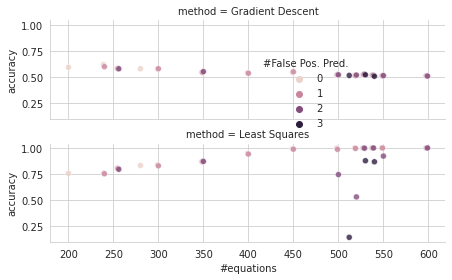

In [54]:
resultpenrose['#False Pos. Pred.'] = resultpenrose['total_fp']
resultpenrose['secret key pred. accuracy'] = resultpenrose['accuracy']
resultpenrose['#equations'] = resultpenrose['size']

mlresult['#False Pos. Pred.'] = mlresult['total_fp']
mlresult['secret key pred. accuracy'] = mlresult['accuracy']
mlresult['#equations'] = mlresult['size']

mlresult['method'] = "Gradient Descent"
resultpenrose['method'] = "Least Squares"

allresults = mlresult.copy().append(resultpenrose)

sns.set_style('whitegrid')
g = sns.relplot(
    x='#equations',
    y='accuracy',
    hue='#False Pos. Pred.',
    row='method',
    data=allresults[(allresults['size']>=200)&(allresults['size'] < 600)&(~allresults['size'].isin([509,510,511,513]))&(allresults['seed'].isin([4,5]))].sort_values('total_fp', ascending=True),
    height=2, 
    aspect=5/2,
    #s=10,
    alpha=.8,
    legend=True,
)
leg = g._legend
leg.set_bbox_to_anchor([0.56, 0.8])  # coordinates of lower left of bounding box
leg._loc = 2
g.fig.tight_layout()

# Plot 

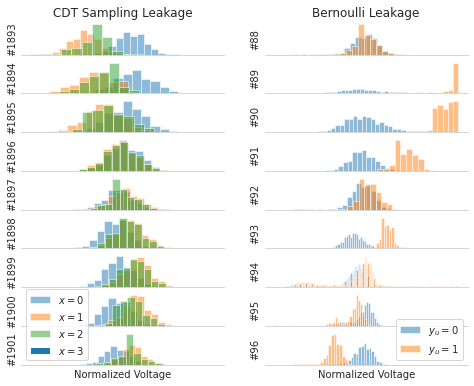

In [55]:
HISTPLOT = list(range(3,12))
f, axes = plt.subplots(nrows=len(HISTPLOT), ncols=2, figsize=(8, .7*len(HISTPLOT)))

LABELS = {'$x=0$': 0, '$x=1$': 256, '$x=2$': 512, '$x=3$': 786, '$x=4$': 1024}

for i, ax in zip(HISTPLOT, axes[:,0]):
    for j, (l, lval) in enumerate(LABELS.items()):
        v = X_kx_train[Y_kx_train==lval][:, i]
        if len(v) == 0: continue
        v = v[np.abs(v) < 2]
        ax.hist(v, density=True, bins=np.linspace(np.min(v), np.max(v), len(np.unique(v))-1), alpha=.5)
    ax.set_ylabel(f'#{1890+i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
axes[-1,0].legend(LABELS.keys())
    
LABELS = {'$y_u=0$': False, '$y_u=1$': True}
    
    
for i, ax in zip(HISTPLOT, axes[:,1]):
    for j, (l, lval) in enumerate(LABELS.items()):
        v = X_yu_train[Y_yu_train==lval][:, i]
        if len(v) == 0: continue
        v = v[np.abs(v) < 2]
        ax.hist(v, density=True, bins=np.linspace(np.min(v), np.max(v), len(np.unique(v))-1), alpha=.5)
    ax.set_ylabel(f'#{85+i}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)    
axes[-1,1].legend(LABELS.keys())

axes[0,0].set_title('CDT Sampling Leakage')
axes[0,1].set_title('Bernoulli Leakage')
axes[-1,0].set_xlabel('Normalized Voltage')
axes[-1,1].set_xlabel('Normalized Voltage')

f.savefig('leakage-hist.pdf')